# Project: Dynamic Pricing in Logistics

## Mentors:
Brady Thompson (Lead)\
Veronika Koubova\
Daniel Prentice\
Matthew Smith\
Orion Wynblatt

## Team Members:
Abhinav Chand\
Zhaobidan (Amy) Feng\
Mengting Chao\
Christian McRoberts

## Our Goal:
- We provide rates for a choice set that balances the probability that something from the choice set is ordered, while also providing a rate that has good profit.
- We use Thompson sampling and different ML models to predict whether the cheapest quote gets ordered, one of the remaining quotes gets ordered, or none of them get ordered, and we found the corresponding rates to maximize EV of profit.


## Data Set:
- Initial Data Set (from Jan to May): *IMA.csv*
- Clean Data Set (from Jan to May): *clean_IMA.csv*
    - We get this data set by running the "Clean the data" section on *IMA.csv*.
    - If you start with *clean_IMA.csv*, then you do not need to run the "Clean the data" section.
- Clean Data Set including testing data (from Jan to June): *clean_IMA2.csv*
    - We use the data from June as our testing data.
    - If you start with *clean_IMA2.csv*, then you do not need to run the "Clean the data" section.

## Column descriptions of the initial data set *IMA.csv*:
- QUOTEID = Unique identifier for each individual quote
- QUOTEREQUESTID =  Unique identifier for each quote request. A single quote request is a collection of quotes. You can think of each quote request as the choice set the customer can choose.
- QUOTEDDATETIME = date quote request was made
- CARRIERCODE = Unique identifier for each carrier
- TOTALRATE_zscore = Normalized Rate for the quote. Rate is what is shown to the customer. We normalized according to Region to Region data cost data.
- TOTALCOST_zscore = Normalized Cost for the quote. Cost is what the carrier charges us. We normalized according to Region to Region data cost data.
- ORDERED = Flag to indicate whether the customer picked the quote. Happens at most one time per quote request.
- ORIGINPOSTALCODE = self-explanatory
- ORIGINREGION = self-explanatory
- DESTINATIONPOSTALCODE = self-explanatory
- DESTINATIONREGION = self-explanatory
- TOTALWEIGHT = Total Weight of shipment
- TOTALPALLETS = Number of pallets of shipment
- AVGFREIGHTCLASS = Freight class is a insustry measure of density. The higher the freighclass the less density or more fragile the load, e.g. ping pong balls, artsy lightbulbs..., the lower the freight class the more dense and less fragile, e.g. bricks, wood etc.

## Table of Contents:
* [1. Clean the data](#1)
    * [1.1 Remove outliers](#1.1)
    * [1.2 Calculate lattitude and longitude](#1.2)
    * [1.3 Calculate distance](#1.3)
    * [1.4 Generate rate and cost](#1.4)
    * [1.5 Turn each quote request into a vector that we can feed into our model](#1.5)
    * [1.6 Add the outcome column 'CHOSEN'](#1.6)
    * [1.7 Generate the clean data set](#1.7)
* [2. Thompson Sampling](#2)
* [3. Machine Leaning Models](#3)
    * [3.1 Get the data for model](#3.1)
    * [3.2 Class Imbalance and Data Augmentation](#3.2)
    * [3.3 XGBoost](#3.3)
        * [3.3.1 Use only 2 predictors: RATE, weigted_rate](#3.3.1)
        * [3.3.2 Use only 2 predictors: PROFIT, weighted_profit](#3.3.2)
        * [3.3.3 Use 4 predictors: RATE, weighted_rate, PROFIT, weighted_profit](#3.3.3)
        * [3.3.4 Use 6 predictors](#3.3.4)
        * [3.3.5 Use 13 predictors](#3.3.5)
        * [3.3.6 Use only 2 classes and only 2 predictors: RATE, weighted_rate](#3.3.6)
        * [3.3.7 Use only 2 classes and only 2 predictors: PROFIT, weighted_profit](#3.3.7)
    * [3.4 CatBoost](#3.4)
    * [3.5 k-Nearest Neighborhoods (kNN)](#3.5)
* [4. Yield surface of expected value of profit](#4)
* [5. Conclusion](#5)
* [Acknowlegement](#6)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
import sklearn
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report, plot_confusion_matrix
import seaborn as sns
import shap
from time import sleep
from tqdm import tqdm

In [2]:
# Read the data in
# If you start with clean_IMA.csv, then you do not need to run the "Clean the data" section.
df = pd.read_csv('./clean_IMA2.csv')

In [3]:
df.head()

,QUOTEID,QUOTEREQUESTID,QUOTEDDATETIME,CARRIERCODE,RATE,COST,ORDERED,ORIGINPOSTALCODE,ORIGINREGION,DESTINATIONPOSTALCODE,...,Distance,TOTALWEIGHT,TOTALPALLETS,AVGFREIGHTCLASS,QuoteRank,weight,weight_scalar,weighted_rate,weighted_cost,CHOSEN
0,59089521,75121901,2022-01-01,441037157,811.544634,793.683874,0,32801,FL-TAM,11416,...,908.413337,30.0,1.0,400.0,1.0,0.000000,1.038961,0.000000,0.000000,0
1,59089522,75121901,2022-01-01,441037168,821.947337,797.114777,0,32801,FL-TAM,11416,...,908.413337,30.0,1.0,400.0,2.0,0.486111,1.038961,415.124917,402.583221,0
2,59089523,75121901,2022-01-01,441037160,832.388149,807.984418,0,32801,FL-TAM,11416,...,908.413337,30.0,1.0,400.0,3.0,0.226389,1.038961,195.785380,190.045397,0
3,59089524,75121901,2022-01-01,441037201,846.234123,818.631061,0,32801,FL-TAM,11416,...,908.413337,30.0,1.0,400.0,4.0,0.105556,1.038961,92.804897,89.777721,0
4,59089525,75121901,2022-01-01,441037165,846.686353,817.072117,0,32801,FL-TAM,11416,...,908.413337,30.0,1.0,400.0,5.0,0.061111,1.038961,53.757864,51.877595,0


In [4]:
df.shape

(407086, 26)

In [5]:
df.dtypes

QUOTEID                    int64
QUOTEREQUESTID             int64
QUOTEDDATETIME            object
CARRIERCODE                int64
RATE                     float64
COST                     float64
ORDERED                    int64
ORIGINPOSTALCODE           int64
ORIGINREGION              object
DESTINATIONPOSTALCODE      int64
DESTINATIONREGION         object
Olat                     float64
Olong                    float64
Dlat                     float64
Dlong                    float64
Lane                      object
Distance                 float64
TOTALWEIGHT              float64
TOTALPALLETS             float64
AVGFREIGHTCLASS          float64
QuoteRank                float64
weight                   float64
weight_scalar            float64
weighted_rate            float64
weighted_cost            float64
CHOSEN                     int64
dtype: object

# 1. Clean the data <a class="anchor" id="1"></a>

If you start with *clean_IMA.csv* or *clean_IMA2*, then you do not need to run the "Clean the data" section.

## 1.1 Remove outliers <a class="anchor" id="1.1"></a>

In [ ]:
# Look for outliers (nans, infs)
df['TOTALRATE_zscore'].describe()

In [ ]:
# Clean the data a bit
bad_qrids = list(df[df['TOTALRATE_zscore']>100000]['QUOTEREQUESTID'])

df = df[~df['QUOTEREQUESTID'].isin(bad_qrids)]

In [ ]:
# Only include data that is DENSE!
more_bad_qrids = (
    df[~(df['TOTALCOST_zscore'].between(-3,3)) | 
       ~(df['TOTALRATE_zscore'].between(-3,3))]['QUOTEREQUESTID'].unique()
)

df = df[~df['QUOTEREQUESTID'].isin(more_bad_qrids)]

In [ ]:
# Check to see if it works
df['TOTALCOST_zscore'].describe()

In [ ]:
# Check to see if it works
df['TOTALRATE_zscore'].describe()

In [ ]:
# First plot
plt.figure(figsize = (10,4))
plt.title('RATE DISTRIBUTION zscore')
plt.hist(df['TOTALRATE_zscore'], rwidth = 0.9, bins = 20, color = 'blue')
plt.xlim(-3, 3)
plt.show()

plt.figure(figsize = (10,4))
plt.title('COST DISTRIBUTION zscore')
plt.hist(df['TOTALCOST_zscore'], rwidth = 0.9, bins = 20, color = 'red')
plt.xlim(-3, 3)
plt.show()

In [ ]:
# Reduce to dense lanes
df['Lane'] = df['ORIGINREGION'] + ' -> ' + df['DESTINATIONREGION']
good_lanes = (
    df.groupby(['Lane'])['QUOTEREQUESTID']
    .nunique()
    .reset_index()
    .sort_values('QUOTEREQUESTID', ascending = False)
    .head(100)['Lane']
)

df = df[df['Lane'].isin(good_lanes)]

In [ ]:
# Look at profit
df['Profit'] = df['TOTALRATE_zscore'] - df['TOTALCOST_zscore']
(
    df.groupby(['Lane']).agg({
        'TOTALRATE_zscore': 'mean',
        'TOTALCOST_zscore': 'mean',
        'Profit':'mean'
    })
    .reset_index()
    .sort_values('Profit', ascending = False)
)

## 1.2 Calculate lattitude and longitude <a class="anchor" id="1.2"></a>

In [ ]:
zips = pd.read_csv('./zip_lat_long.csv')

In [ ]:
list(zips)

In [ ]:
df['ORIGINPOSTALCODE'] = df['ORIGINPOSTALCODE'].astype(str).str.pad(width = 5, side = 'left', fillchar = '0')
df['DESTINATIONPOSTALCODE'] = df['DESTINATIONPOSTALCODE'].astype(str).str.pad(width = 5, side = 'left', fillchar = '0')
zips['zipcode'] = zips['zipcode'].astype(str).str.pad(width = 5, side = 'left', fillchar= '0')

In [ ]:
zips_o = zips.copy()
zips_o.columns = ['ORIGINPOSTALCODE', 'Olat', 'Olong']

df = df.merge(zips_o, on = ['ORIGINPOSTALCODE'], how = 'left')

In [ ]:
zips_d = zips.copy()
zips_d.columns = ['DESTINATIONPOSTALCODE', 'Dlat', 'Dlong']

df = df.merge(zips_d, on = ['DESTINATIONPOSTALCODE'], how = 'left')

In [ ]:
mean_o_lats = dict(df.groupby('ORIGINREGION')['Olat'].mean())
mean_o_longs = dict(df.groupby('ORIGINREGION')['Olong'].mean())
df['olat_test'] = df['ORIGINREGION'].map(mean_o_lats)
df['olong_test'] = df['ORIGINREGION'].map(mean_o_longs)
df['Olat'] = (df['Olat'].fillna(0) + 1*(df['Olat'].isna())*df['olat_test'])
df['Olong'] = (df['Olong'].fillna(0) + 1*(df['Olong'].isna())*df['olong_test'])

In [ ]:
mean_d_lats = dict(df.groupby('DESTINATIONREGION')['Dlat'].mean())
mean_d_longs = dict(df.groupby('DESTINATIONREGION')['Dlong'].mean())
df['dlat_test'] = df['DESTINATIONREGION'].map(mean_d_lats)
df['dlong_test'] = df['DESTINATIONREGION'].map(mean_d_longs)
df['Dlat'] = (df['Dlat'].fillna(0) + 1*(df['Dlat'].isna())*df['dlat_test'])
df['Dlong'] = (df['Dlong'].fillna(0) + 1*(df['Dlong'].isna())*df['dlong_test'])

## 1.3 Galculate distance <a class="anchor" id="1.3"></a>

In [ ]:
def get_distance(olat, olong, dlat, dlong):
    vector = pd.concat([olat, olong, dlat, dlong], axis=1).astype(float)
    vector.columns = ['olat', 'olng', 'dlat', 'dlng']
    radians = vector.apply(np.radians)

    dlat = radians['dlat'] - radians['olat']
    dlng = radians['dlng'] - radians['olng']
    
    a = np.sin(dlat / 2.0) ** 2 + np.cos(radians['olat']) * np.cos(radians['dlat']) * np.sin(dlng / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    mi = 6371.0 * c * 0.6
    return mi

In [ ]:
df['Distance'] = get_distance(df['Olat'], df['Olong'], df['Dlat'], df['Dlong'])
df['Distance'] = df['Distance'].clip(15)

## 1.4 Generate rate and cost <a class="anchor" id="1.4"></a>

In [ ]:
# Define std to be 10% of the distance to make RATE and COST always be positive
stdevs = df.groupby('Lane')['Distance'].mean().reset_index()
stdevs['std'] = 0.1 * stdevs['Distance']
stdevs = stdevs.drop(columns = ['Distance'])
df = df.merge(stdevs, on = ['Lane'], how = 'left')

In [ ]:
df['RATE'] = df['TOTALRATE_zscore'] * df['std'] + df['Distance']
df['COST'] = df['TOTALCOST_zscore'] * df['std'] + df['Distance']

In [ ]:
df = df[[
    'QUOTEID',
    'QUOTEREQUESTID',
    'QUOTEDDATETIME',
    'CARRIERCODE',
    'RATE',
    'COST',
    'ORDERED',
    'ORIGINPOSTALCODE',
    'ORIGINREGION',
    'DESTINATIONPOSTALCODE',
    'DESTINATIONREGION',
    'Olat',
    'Olong',
    'Dlat',
    'Dlong',
    'Lane',
    'Distance',
    'TOTALWEIGHT',
    'TOTALPALLETS',
    'AVGFREIGHTCLASS'
]]

In [ ]:
df = df.sort_values(['QUOTEREQUESTID', 'QUOTEDDATETIME', 'RATE'])
df['RATE'] = df['RATE'] + np.random.uniform(-0.05, 0.05, size = df.shape[0])
df['QuoteRank'] = df.groupby('QUOTEREQUESTID')['RATE'].rank()
df['AVGFREIGHTCLASS'] = df['AVGFREIGHTCLASS'].clip(lower = 50)

## 1.5 Turn each quote request into a vector that we can feed into our model <a class="anchor" id="1.5"></a>

In [3]:
# We wanted a weighted mean for the rates and costs for choice option 2
temp = df[df['QuoteRank'] != 1]
counts = temp[temp['ORDERED'] == 1]['QuoteRank'].value_counts()
total = temp[temp['ORDERED'] == 1]['QuoteRank'].value_counts().reset_index()['QuoteRank'].sum()
weight_map = counts / total
df['weight'] = df['QuoteRank'].map(weight_map).fillna(0)

In [4]:
# We realized some quote requests have fewer options 
# so we scale the weights to get them all and sum to 1 across quote request id.
weight_scalar = 1 / df.groupby('QUOTEREQUESTID')['weight'].sum()
df['weight_scalar'] = df['QUOTEREQUESTID'].map(weight_scalar)
df['weighted_rate'] = df['RATE'] * df['weight'] * df['weight_scalar']
df['weighted_cost'] = df['COST'] * df['weight'] * df['weight_scalar']

In [ ]:
temp2 = df.groupby('QUOTEREQUESTID')['weighted_rate'].sum()
df['weighted_rate_sum'] = df['QUOTEREQUESTID'].map(temp2)

temp3 = df.groupby('QUOTEREQUESTID')['weighted_cost'].sum()
df['weighted_cost_sum'] = df['QUOTEREQUESTID'].map(temp3)

## 1.6 Add the outcome column 'CHOSEN' <a class="anchor" id="1.6"></a>

In [ ]:
# CHOSEN = 0 when nothing was chosen
# CHOSEN = 1 when the cheapest was chosen
# CHOSEN = 2 when not the cheapest was chosen
conditions = [
    (df['ORDERED'] == 1) & (df['QuoteRank'] == 1),
    (df['ORDERED'] == 1) & (df['QuoteRank'] != 1),
    (df['ORDERED'] != 1)
]

values = [1, 2, 0]
df['CHOSEN'] = np.select(conditions, values)

## 1.7 Generate the clean data set <a class="anchor" id="1.7"></a>

In [ ]:
df.to_csv('clean_IMA.csv', header = True, index = False)

# 2. Thompson Sampling <a class="anchor" id="2"></a>

- The code below is copied from "How to Do Thompson Sampling Using Python," an article by James McCaffrey at https://visualstudiomagazine.com/articles/2019/06/01/thompson-sampling.aspx. It was meant to serve as a base as we created dynamic pricing stratergies, but we were unable to get to it.
- Given n pricing strategies, we wanted to explore the strategies and then begin to exploit the strategy that maximizes our expected reward (or profits). The strategies, which depend on metrics from the data is highly nuanced, but we believe this is a great start for understanding and implementation.

In [150]:
# thompson.py
# Python 3.6.5

import numpy as np

def main():
  print("Begin Thompson sampling demo ")
  print("Goal is to maximize payout from pricing strategies")
  print("Each pricing strategy 'succeed' with probability vector means = [x_1,x_2,...,x_n].")

  N = 3  # number of quotes
  means = np.array([0,0,0,0,0])
  probs = np.zeros(N)
  S = np.zeros(N, dtype=np.int)
  F = np.zeros(N, dtype=np.int)
  rnd = np.random.RandomState(21)

  for trial in range(100):
    print("\nTrial " + str(trial))

    for i in range(N):
      probs[i] = rnd.beta(S[i] + 1, F[i] + 1)

    print("sampling probs =  ", end="")
    for i in range(N):
      print("%0.4f  " % probs[i], end="")
    print("")

    machine = np.argmax(probs)
    print("Inspecting pricing strategy " + str(machine), end="")

    p = rnd.random_sample()  # [0.0, 1.0)
    if p <= means[machine]:
      print(" -- purchase")
      S[machine] += 1
    else:
      print(" -- no purchase")
      F[machine] += 1

  print("Final Success vector: ", end="")
  print(S)
  print("Final Failure vector: ", end="")
  print(F)

if __name__ == "__main__":
  main()

Begin Thompson sampling demo 
Goal is to maximize payout from pricing strategies
Each pricing strategy 'succeed' with probability vector means = [x_1,x_2,...,x_n].

Trial 0
sampling probs =  0.1442  0.9709  0.8022  
Inspecting pricing strategy 1 -- no purchase

Trial 1
sampling probs =  0.6830  0.3824  0.4846  
Inspecting pricing strategy 0 -- no purchase

Trial 2
sampling probs =  0.1859  0.5755  0.5127  
Inspecting pricing strategy 1 -- no purchase

Trial 3
sampling probs =  0.1154  0.0597  0.3032  
Inspecting pricing strategy 2 -- no purchase

Trial 4
sampling probs =  0.1391  0.2773  0.4731  
Inspecting pricing strategy 2 -- no purchase

Trial 5
sampling probs =  0.6499  0.1978  0.1269  
Inspecting pricing strategy 0 -- no purchase

Trial 6
sampling probs =  0.6324  0.2160  0.4203  
Inspecting pricing strategy 0 -- no purchase

Trial 7
sampling probs =  0.2900  0.1809  0.0082  
Inspecting pricing strategy 0 -- no purchase

Trial 8
sampling probs =  0.2491  0.0844  0.5641  
Inspecti

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


# 3. Machine Learning Models <a class="anchor" id="3"></a>

## 3.1 Get the data for model <a class="anchor" id="3.1"></a>

In [7]:
# Sum up weighted_rate
tempp = df.groupby('QUOTEREQUESTID')['weighted_rate'].sum()
df['weighted_rate'] = df['QUOTEREQUESTID'].map(tempp)

In [8]:
# Sum up weighted_cost
temp = df.groupby('QUOTEREQUESTID')['weighted_cost'].sum()
df['weighted_cost'] = df['QUOTEREQUESTID'].map(temp)

In [9]:
# QuoteRank was float initially
df['QuoteRank'] = df['QuoteRank'].astype(int)

In [10]:
# Change to datetime format
df['QUOTEDDATETIME'] = pd.to_datetime(df['QUOTEDDATETIME'])

In [11]:
# This is a feature that we want to add
df['CARRIER_PREFERENCE'] = df['ORDERED'].groupby(df['CARRIERCODE']).transform(sum)

In [12]:
df['lane'] = df['ORIGINREGION'] + '->' + df['DESTINATIONREGION']

In [13]:
df['lane_volume'] = df['QUOTEREQUESTID'].groupby(df['lane']).transform('nunique')

In [14]:
df['PROFIT'] = df['RATE'] - df['COST']

In [15]:
df['lane_profit'] = df['PROFIT'].groupby(df['lane']).transform('mean')

In [16]:
df['QUOTEDDATETIME'] = pd.to_datetime(df['QUOTEDDATETIME'])
df['dayofweek'] = df['QUOTEDDATETIME'].dt.day_name()
df = df.replace({'Monday':0,'Tuesday':1,'Wednesday':2,'Thursday':3,'Friday':4,'Saturday':5,'Sunday':6})

In [17]:
bent = df.groupby('QUOTEREQUESTID')['CARRIER_PREFERENCE'].first()
df['CARRIER_LOW'] = df['QUOTEREQUESTID'].map(bent)

In [18]:
temp = df[df['QuoteRank']!=1]
counts = temp.groupby('QUOTEREQUESTID')['CARRIER_PREFERENCE'].mean()
df['CARRIER_HIGH']=df['QUOTEREQUESTID'].map(counts)

In [19]:
# We can now aggregate to get a single row for each quote request
for_model = df.groupby('QUOTEREQUESTID').agg({
    'RATE':'first',
    'COST':'first',
    'weighted_rate':'max',
    'weighted_cost':'max',
    'Distance':'first',
    'TOTALWEIGHT':'first',
    'TOTALPALLETS':'first',
    'AVGFREIGHTCLASS':'first',
    'ORIGINREGION':'first',
    'DESTINATIONREGION':'first',
    'CHOSEN':'max',
    'CARRIER_LOW':'first',
    'CARRIER_HIGH':'first',
    'lane_volume':'first',
    'lane_profit':'first',
    'dayofweek':'first',
    'QUOTEDDATETIME':'first'
}).reset_index()

## 3.2 Class Imbalance and Data Augmentation <a class="anchor" id="3.2"></a>

### Split the data into training/testing data

In [20]:
# Split for_model into train and test
for_model_train = for_model[for_model['QUOTEDDATETIME'] <= "2022-05-31"]
for_model_test = for_model[for_model['QUOTEDDATETIME'] > "2022-05-31"]

In [21]:
for_model_train

,QUOTEREQUESTID,RATE,COST,weighted_rate,weighted_cost,Distance,TOTALWEIGHT,TOTALPALLETS,AVGFREIGHTCLASS,ORIGINREGION,DESTINATIONREGION,CHOSEN,CARRIER_LOW,CARRIER_HIGH,lane_volume,lane_profit,dayofweek,QUOTEDDATETIME
0,75121901,811.544634,793.683874,831.673475,805.069440,908.413337,30.0,1.0,400.0,FL-TAM,NY-NY,0,94,107.000000,182,60.919164,5,2022-01-01
1,75121903,1605.584227,1533.014084,1682.520949,1576.106603,1670.337302,1000.0,1.0,100.0,CA-LA,IL-CHI,0,101,100.125000,499,124.178622,5,2022-01-01
2,75121904,1638.586292,1539.423409,1684.313438,1577.099242,1670.337302,800.0,1.0,110.0,CA-LA,IL-CHI,0,101,100.125000,499,124.178622,5,2022-01-01
3,75121911,2039.930338,1977.135295,2130.019785,2021.494002,2254.083395,200.0,1.0,250.0,CA-LA,FL-MIA,0,124,79.200000,715,165.983742,5,2022-01-01
4,75121939,1544.061388,1506.215450,1655.083263,1573.487953,1676.309664,240.0,1.0,250.0,IL-CHI,CA-LA,0,124,52.923077,479,95.204653,5,2022-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25045,75327706,1714.834035,1661.705246,1732.976100,1664.547351,1871.403958,15.0,1.0,150.0,CA-LA,GA-ATL,0,371,70.642857,339,152.839269,4,2022-05-27
25046,75327723,2209.117612,2128.946870,2489.584972,2304.578928,2252.911263,2450.0,1.0,50.0,FL-MIA,CA-LA,0,124,92.307692,312,204.634588,4,2022-05-27
25047,75327730,2551.849629,2439.404795,2821.233768,2598.240464,2584.694336,1000.0,1.0,100.0,CA-SF,MA-BOS,0,124,86.642857,169,254.510902,4,2022-05-27
25048,75327735,322.649194,304.082340,354.412634,324.827107,334.685408,450.0,1.0,200.0,CA-LA,CA-SF,0,142,102.800000,1059,31.333739,4,2022-05-27


### Class Imbalance

In [22]:
# There is a pretty bad class imbalance in our target variable 'CHOSEN'.
count = for_model_train['CHOSEN'].value_counts()
count

0    22078
1      934
2      535
Name: CHOSEN, dtype: int64

([<matplotlib.axis.XTick at 0x7f924218d3d0>,
 [Text(0, 0, 'CHOSEN = 0'),
  Text(1, 0, 'CHOSEN = 1'),
  Text(2, 0, 'CHOSEN = 2')])

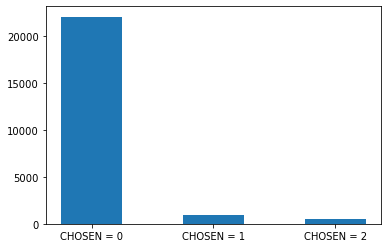

In [23]:
# Histogram of 'CHOSEN' values
plt.bar([0, 1, 2], count, width = 0.5)
X_axis = np.arange(3)
plt.xticks(X_axis, ['CHOSEN = 0', 'CHOSEN = 1', 'CHOSEN = 2'])

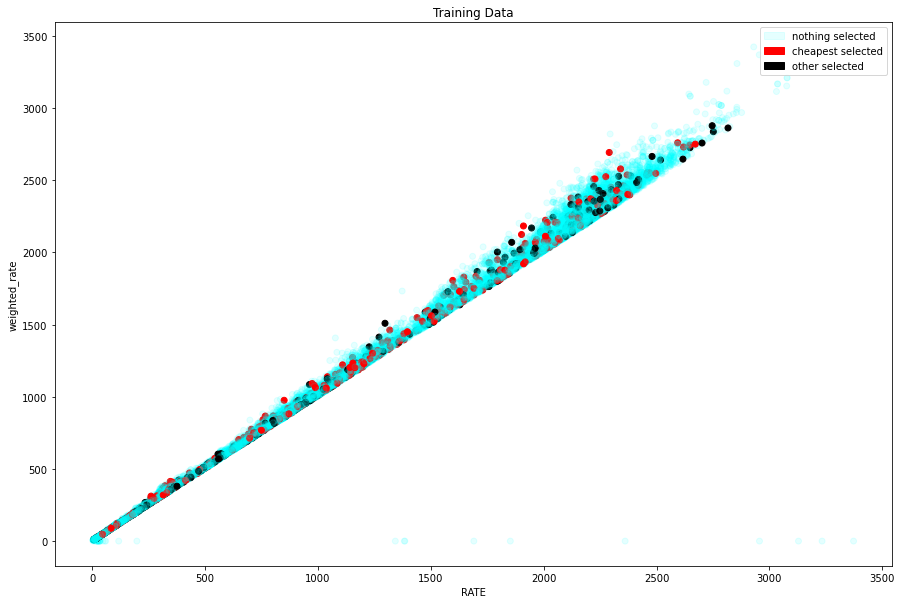

In [24]:
# Generate the scatter plot of training data
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

colors = {0:(0,1,1,0.1), 1:'red', 2:'black'}
scatter = ax.scatter(for_model_train['RATE'], for_model_train['weighted_rate'], c = for_model_train['CHOSEN'].map(colors), label = colors)

yellow_color = mpatches.Patch(color = (0,1,1,0.1), label = 'nothing selected')
red_color = mpatches.Patch(color = 'red', label = 'cheapest selected')
black_color = mpatches.Patch(color = 'black', label = 'other selected')

plt.legend(handles=[yellow_color, red_color, black_color])

plt.xlabel('RATE')
plt.ylabel('weighted_rate')
plt.title('Training Data')
plt.show()

In [25]:
# We had to define some extreme value for weighted rate and weighted cost when there was only 1 choice
for_model_train['weighted_rate'] = for_model_train['weighted_rate'].replace(to_replace=0, value=100000)
for_model_train['weighted_cost'] = for_model_train['weighted_cost'].replace(to_replace=0, value=99900)
for_model_test['weighted_rate'] = for_model_test['weighted_rate'].replace(to_replace=0, value=100000)
for_model_test['weighted_cost'] = for_model_test['weighted_cost'].replace(to_replace=0, value=99900)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

### Augment the training data

In [26]:
# We augment the data to correct class imbalance.
df0 = for_model_train[for_model_train['CHOSEN']==0]
df1 = for_model_train[for_model_train['CHOSEN']==1]
df2 = for_model_train[for_model_train['CHOSEN']==2]

N_augmentations_class1 = 22
X = np.linspace(df1['RATE'], df1['COST'], N_augmentations_class1)
df1_dict={}
for i in range(N_augmentations_class1-2):
    df1_dict[i+1] = df1.copy()
    df1_dict[i+1]['RATE'] = X[i+1,]
    
N_augmentations_class2 = 20
X = np.linspace(df2['weighted_rate'], 
                df2['weighted_cost'], 
                N_augmentations_class2)
df2_dict = {}
for i in range(N_augmentations_class2-2):
    df2_dict[i+1] = df2.copy()
    df2_dict[i+1]['weighted_rate'] = X[i+1,]

df1_aug = pd.concat(df1_dict)
df2_aug = pd.concat(df2_dict)
for_model_train = pd.concat([
    df0,
    df1,
    df2,
    df1_aug,
    df2_aug])

In [27]:
# Add 'PROFIT' and 'weighted_profit'
for_model_train['PROFIT'] = for_model_train['RATE'] - for_model_train['COST']
for_model_train['weighted_profit'] = for_model_train['weighted_rate'] - for_model_train['weighted_cost']
for_model_test['PROFIT'] = for_model_test['RATE'] - for_model_test['COST']
for_model_test['weighted_profit'] = for_model_test['weighted_rate'] - for_model_test['weighted_cost']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
# Check if we correct class imbalance for the training data
for_model_train['CHOSEN'].value_counts()

0    22078
1    19614
2    10165
Name: CHOSEN, dtype: int64

## 3.3 XGBoost <a class="anchor" id="3.3"></a>

- XGBoost (Extreme Gradient Boosting) is one of the most popular and efficient implementations of the Gradient Boosted Trees algorithm, a supervised learning method that is based on function approximation by optimizing specific loss functions as well as applying several regularization techniques.
- How it works:
    - Iteratively add new trees that complements the already-built ones.
    - Use regularization to penalize complexity of the model.
    - Response is the optimal linear combination of CARTs (Classification and Regression Tree).

We need to fine tune these parameters to get the best prediction.

### 3.3.1 Use only 2 predictors: RATE, weigted_rate <a class="anchor" id="3.3.1"></a>

#### Train XGBoost

In [29]:
# We create the predictors and the response
X1_train = for_model_train[[
    'RATE',
    'weighted_rate',
]]

y1_train = for_model_train['CHOSEN']

In [30]:
# This is how to produce the model object. 
# We need to look through the documentation and try to tune these hyper parameters 
# until we get a "smooth" yield surface. 

# For example, we might want more than 100 estimators.
Model1 = XGBClassifier(base_score=0.5,
                    booster='gbtree',
                    colsample_bylevel=1,
                    colsample_bynode=1,
                    colsample_bytree=1,
                    gamma=0.5,
                    gpu_id=-1,
                    importance_type='gain',
                    interaction_constraints='',
                    learning_rate=.3,
                    max_delta_step=0,
                    max_depth=5,
                    min_child_weight=1,
                    missing=np.nan,
#                     monotone_constraints='(-1,0)',
                    n_estimators=100,
                    n_jobs=0,
                    num_parallel_tree=1,
                    objective='multi:softprob',
                    random_state=0,
                    reg_alpha=0,
                    reg_lambda=1,
                    scale_pos_weight=None,
                    subsample=0.5,
                    tree_method='exact',
                    validate_parameters=1,
                    verbosity=None
                    )

In [31]:
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
results = cross_val_score(Model1, X1_train, y1_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 75.02% (0.66%)


In [32]:
Model1.fit(X1_train, y1_train)  

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

#### Confusion Matrix

In [33]:
X1_test = for_model_test[[
     'RATE',
     'weighted_rate',
     
]]

y1_test = for_model_test['CHOSEN']

In [34]:
preds1 = Model1.predict(X1_test)

ACCURACY:  0.7275789473684211


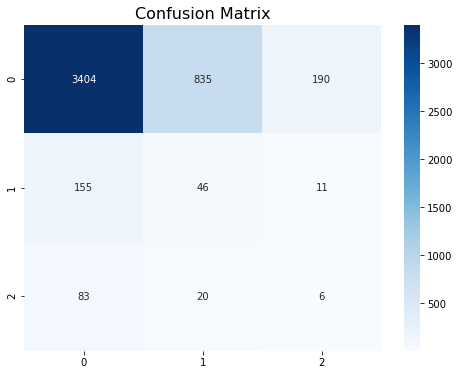

In [35]:
# Evaluate
print("ACCURACY: ", accuracy_score(y1_test, preds1))
cm = confusion_matrix(y1_test, preds1)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix', size=16)
plt.xlabel('PREDICTED LABELS')
plt.ylabel('TRUE LABELS')
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues');


#### F-score

In [36]:
print(classification_report(y1_test, preds1))

              precision    recall  f1-score   support

           0       0.93      0.77      0.84      4429
           1       0.05      0.22      0.08       212
           2       0.03      0.06      0.04       109

    accuracy                           0.73      4750
   macro avg       0.34      0.35      0.32      4750
weighted avg       0.87      0.73      0.79      4750



#### SHAP

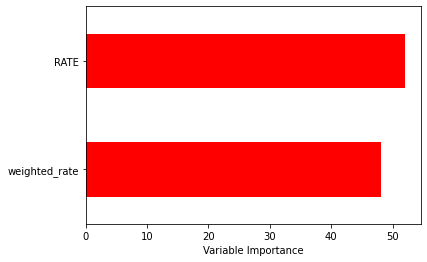

In [37]:
feature_importance = Model1.feature_importances_*100

rel_imp = pd.Series(feature_importance, 
                    index = X1_test.columns).sort_values(inplace = False)

rel_imp.T.plot(kind = 'barh', 
               color = 'r', )

plt.xlabel('Variable Importance')

plt.gca().legend_ = None

In [38]:
# Fits the explainer
explainer = shap.Explainer(Model1.predict, X1_test)
# Calculates the SHAP values - takes some time
shap_values = explainer(X1_test)

Exact explainer: 4751it [00:36, 99.60it/s]                           


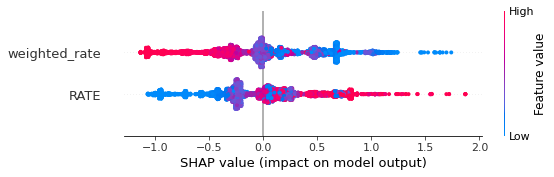

In [39]:
shap.plots.beeswarm(shap_values)

When the cheapest rate is high on average, the customer is more likely to not make any order.

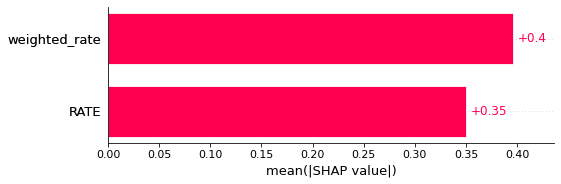

In [40]:
shap.plots.bar(shap_values)

### 3.3.2 Use only 2 predictors: PROFIT, weighted_profit <a class="anchor" id="3.3.2"></a>

#### Train XGBoost

In [41]:
X2_train = for_model_train[[
     'PROFIT',
     'weighted_profit'
]]

y2_train = for_model_train['CHOSEN']

In [42]:
Model2 = XGBClassifier(base_score=0.5,
                    booster='gbtree',
                    colsample_bylevel=1,
                    colsample_bynode=1,
                    colsample_bytree=1,
                    gamma=0.5,
                    gpu_id=-1,
                    importance_type='gain',
                    interaction_constraints='',
                    learning_rate=.3,
                    max_delta_step=0,
                    max_depth=5,
                    min_child_weight=1,
                    missing=np.nan,
                    n_estimators=100,
                    n_jobs=0,
                    num_parallel_tree=1,
                    objective='multi:softprob',
                    random_state=0,
                    reg_alpha=0,
                    reg_lambda=1,
                    scale_pos_weight=None,
                    subsample=.5,
                    tree_method='exact',
                    validate_parameters=1,
                    verbosity=None
                    )

In [43]:
kfold = KFold(n_splits=10, random_state=7,shuffle=True)
results = cross_val_score(Model2, X2_train, y2_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 81.25% (0.40%)


In [44]:
Model2.fit(X2_train, y2_train)  

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

#### Confusion Matrix

In [45]:
X2_test= for_model_test[[
     'PROFIT',
     'weighted_profit'
]]

y2_test = for_model_test['CHOSEN']

In [46]:
preds2 = Model2.predict(X2_test)

ACCURACY:  0.8465263157894737


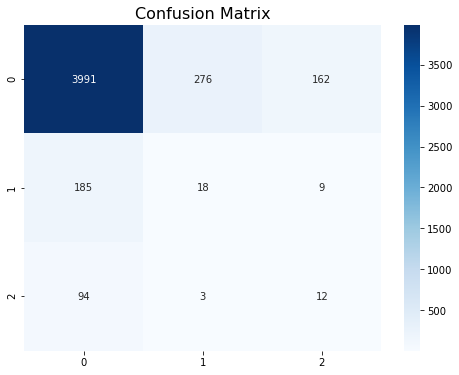

In [47]:
# Evaluate
print("ACCURACY: ", accuracy_score(y2_test, preds2))
cm = confusion_matrix(y2_test, preds2)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix', size=16)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues');

#### F-Score

In [48]:
print(classification_report(y2_test, preds2))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92      4429
           1       0.06      0.08      0.07       212
           2       0.07      0.11      0.08       109

    accuracy                           0.85      4750
   macro avg       0.35      0.37      0.36      4750
weighted avg       0.88      0.85      0.86      4750



#### SHAP

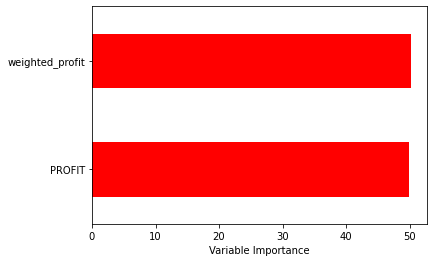

In [49]:
feature_importance = Model2.feature_importances_*100

rel_imp = pd.Series(feature_importance, 
                    index = X2_test.columns).sort_values(inplace = False)

rel_imp.T.plot(kind = 'barh', 
               color = 'r', )

plt.xlabel('Variable Importance')

plt.gca().legend_ = None

In [50]:
# Fits the explainer
explainer = shap.Explainer(Model2.predict, X2_test)
# Calculates the SHAP values - takes some time
shap_values = explainer(X2_test)

Exact explainer: 4751it [00:40, 84.47it/s]                           


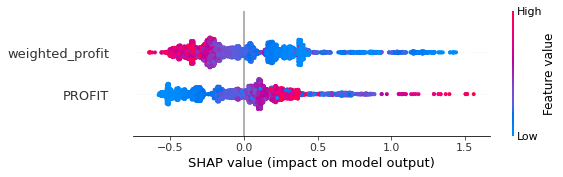

In [51]:
shap.plots.beeswarm(shap_values)

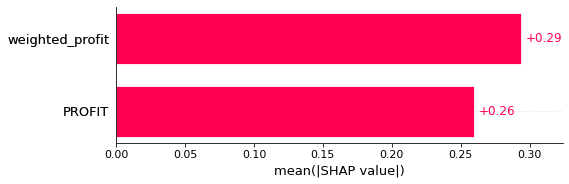

In [52]:
shap.plots.bar(shap_values)

### 3.3.3 Use 4 predictors: RATE, weighted_rate, PROFIT, weighted_profit <a class="anchor" id="3.3.3"></a>

#### Train XGBoost

In [53]:
X3_train = for_model_train[[
     'RATE',
     'weighted_rate',
     'PROFIT',
     'weighted_profit'
]]

y3_train = for_model_train['CHOSEN']

In [54]:
Model3 = XGBClassifier(base_score=0.5,
                    booster='gbtree',
                    colsample_bylevel=1,
                    colsample_bynode=1,
                    colsample_bytree=1,
                    gamma=0.5,
                    gpu_id=-1,
                    importance_type='gain',
                    interaction_constraints='',
                    learning_rate=.3,
                    max_delta_step=0,
                    max_depth=5,
                    min_child_weight=1,
                    missing=np.nan,
                    n_estimators=100,
                    n_jobs=0,
                    num_parallel_tree=1,
                    objective='multi:softprob',
                    random_state=0,
                    reg_alpha=0,
                    reg_lambda=1,
                    scale_pos_weight=None,
                    subsample=.5,
                    tree_method='exact',
                    validate_parameters=1,
                    verbosity=None
                    )  

In [55]:
kfold = KFold(n_splits=10, random_state=7,shuffle=True)
results = cross_val_score(Model3, X3_train, y3_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 85.17% (0.47%)


In [56]:
Model3.fit(X3_train, y3_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

#### Confusion Matrix

In [57]:
X3_test = for_model_test[[
     'RATE',
     'weighted_rate',
     'PROFIT',
     'weighted_profit'
]]

y3_test = for_model_test['CHOSEN']

In [58]:
preds3 = Model3.predict(X3_test)

ACCURACY:  0.8677894736842106


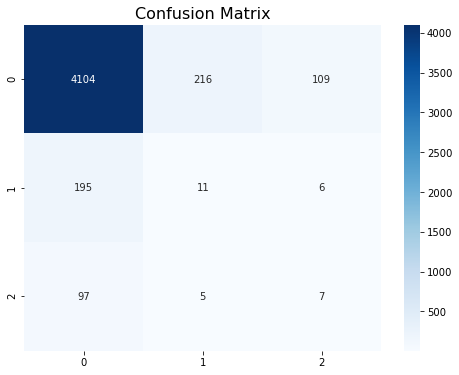

In [59]:
# Evaluate
print("ACCURACY: ", accuracy_score(y3_test, preds3))
cm = confusion_matrix(y3_test, preds3)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix', size=16)
sns.heatmap(cm, annot=True,fmt="d", cmap='Blues');

#### F-Score

In [60]:
print(classification_report(y3_test, preds3))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      4429
           1       0.05      0.05      0.05       212
           2       0.06      0.06      0.06       109

    accuracy                           0.87      4750
   macro avg       0.35      0.35      0.35      4750
weighted avg       0.87      0.87      0.87      4750



#### SHAP

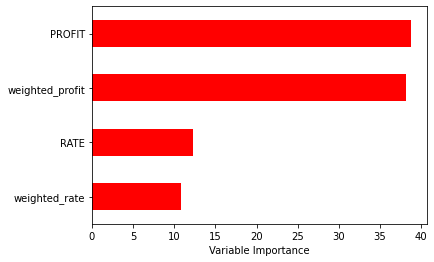

In [61]:
feature_importance = Model3.feature_importances_*100

rel_imp = pd.Series(feature_importance, 
                    index = X3_test.columns).sort_values(inplace = False)

rel_imp.T.plot(kind = 'barh', 
               color = 'r', )

plt.xlabel('Variable Importance')

plt.gca().legend_ = None

In [62]:
# Fits the explainer
explainer = shap.Explainer(Model3.predict, X3_test)
# Calculates the SHAP values - takes some time
shap_values = explainer(X3_test)

Exact explainer: 4751it [00:48, 77.08it/s]                           


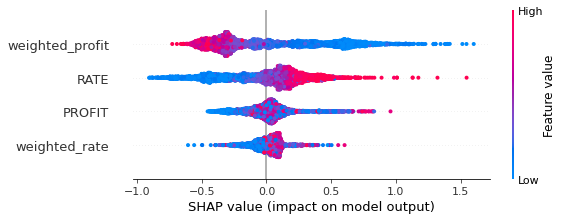

In [63]:
shap.plots.beeswarm(shap_values)

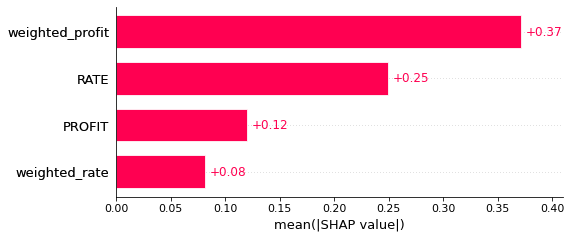

In [64]:
shap.plots.bar(shap_values)

### 3.3.4 Use 6 predictors <a class="anchor" id="3.3.4"></a>

#### Train XGBoost

In [65]:
X4_train = for_model_train[[
     'RATE',
     'weighted_rate',
     'Distance',
     'TOTALWEIGHT',
     'TOTALPALLETS',
     'AVGFREIGHTCLASS'
]]

y4_train = for_model_train['CHOSEN']

In [66]:
Model4 = XGBClassifier(base_score=0.5,
                    booster='gbtree',
                    colsample_bylevel=1,
                    colsample_bynode=1,
                    colsample_bytree=1,
                    gamma=0.5,
                    gpu_id=-1,
                    importance_type='gain',
                    interaction_constraints='',
                    learning_rate=.3,
                    max_delta_step=0,
                    max_depth=7,
                    min_child_weight=1,
                    missing=np.nan,
                    n_estimators=100,
                    n_jobs=0,
                    num_parallel_tree=1,
                    objective='multi:softprob',
                    random_state=0,
                    reg_alpha=0,
                    reg_lambda=1,
                    scale_pos_weight=None,
                    subsample=.5,
                    tree_method='exact',
                    validate_parameters=1,
                    verbosity=None
                    )

In [67]:
kfold = KFold(n_splits=10, random_state=7,shuffle=True)
results = cross_val_score(Model4, X4_train, y4_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 94.78% (0.34%)


In [68]:
Model4.fit(X4_train, y4_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

#### Confusion Matrix

In [69]:
X4_test= for_model_test[[
     'RATE',
     'weighted_rate',
     'Distance',
     'TOTALWEIGHT',
     'TOTALPALLETS',
     'AVGFREIGHTCLASS'
     
]]

y4_test = for_model_test['CHOSEN']

In [70]:
preds4 = Model4.predict(X4_test)

ACCURACY:  0.8631578947368421


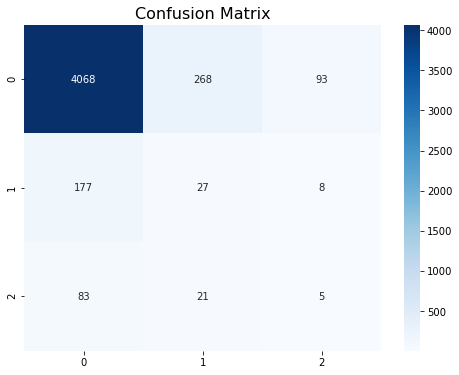

In [71]:
# Evaluate
print("ACCURACY: ", accuracy_score(y4_test, preds4))
cm = confusion_matrix(y4_test, preds4)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix', size=16)
sns.heatmap(cm, annot=True,fmt="d", cmap='Blues');


#### F-Score

In [72]:
print(classification_report(y4_test, preds4))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      4429
           1       0.09      0.13      0.10       212
           2       0.05      0.05      0.05       109

    accuracy                           0.86      4750
   macro avg       0.36      0.36      0.36      4750
weighted avg       0.88      0.86      0.87      4750



#### SHAP

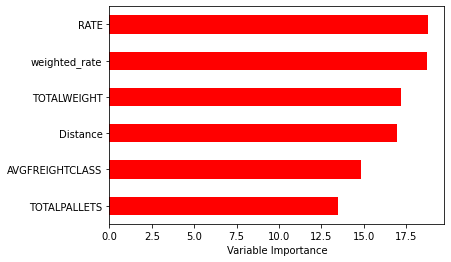

In [73]:
feature_importance = Model4.feature_importances_*100

rel_imp = pd.Series(feature_importance, 
                    index = X4_test.columns).sort_values(inplace = False)

rel_imp.T.plot(kind = 'barh', 
               color = 'r', )

plt.xlabel('Variable Importance')

plt.gca().legend_ = None

In [74]:
# Fits the explainer
explainer = shap.Explainer(Model4.predict, X4_test)
# Calculates the SHAP values - takes some time
shap_values = explainer(X4_test)

Exact explainer: 4751it [01:42, 41.79it/s]                          


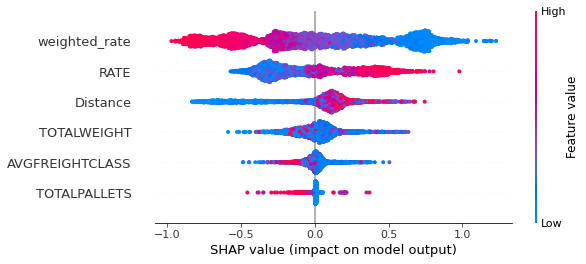

In [75]:
shap.plots.beeswarm(shap_values)

- For orders with large distances, the customer is more likely to choose the cheapest quote.
- For orders with heavy weights the customer is more likely to choose the cheapest quote
- For orders with low freight class the customer is more likely to choose the more expensive quote.

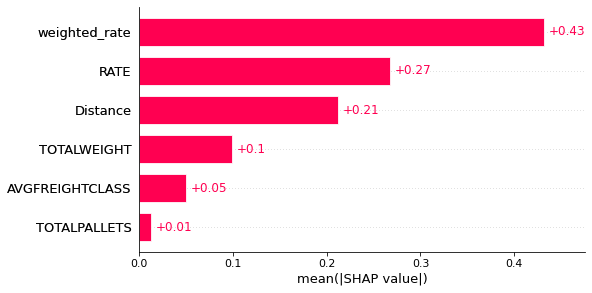

In [76]:
shap.plots.bar(shap_values)

### 3.3.5 Use 13 predictors <a class="anchor" id="3.3.5"></a>

#### Train XGBoost

In [77]:
X5_train = for_model_train[[
     'RATE',
     'weighted_rate',
     'Distance',
     'TOTALWEIGHT',
     'TOTALPALLETS',
     'AVGFREIGHTCLASS',
     'CARRIER_LOW',
     'CARRIER_HIGH',
     'lane_volume',
     'lane_profit',
     'dayofweek',
     'PROFIT',
     'weighted_profit'
]]

y5_train = for_model_train['CHOSEN']

In [78]:
Model5 = XGBClassifier(base_score=0.5,
                    booster='gbtree',
                    colsample_bylevel=1,
                    colsample_bynode=1,
                    colsample_bytree=1,
                    gamma=0.5,
                    gpu_id=-1,
                    importance_type='gain',
                    interaction_constraints='',
                    learning_rate=.3,
                    max_delta_step=0,
                    max_depth=5,
                    min_child_weight=1,
                    missing=np.nan,
                    n_estimators=100,
                    n_jobs=0,
                    num_parallel_tree=1,
                    objective='multi:softprob',
                    random_state=0,
                    reg_alpha=0,
                    reg_lambda=1,
                    scale_pos_weight=None,
                    subsample=.5,
                    tree_method='exact',
                    validate_parameters=1,
                    verbosity=None
                    )

In [79]:
kfold = KFold(n_splits=10, random_state=7,shuffle=True)
results = cross_val_score(Model5, X5_train, y5_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 92.54% (0.40%)


In [80]:
Model5.fit(X5_train, y5_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

#### Confusion Matrix

In [81]:
X5_test= for_model_test[[
     'RATE',
     'weighted_rate',
     'Distance',
     'TOTALWEIGHT',
     'TOTALPALLETS',
     'AVGFREIGHTCLASS',
     'CARRIER_LOW',
     'CARRIER_HIGH',
     'lane_volume',
     'lane_profit',
     'dayofweek',
     'PROFIT',
     'weighted_profit'
]]

y5_test = for_model_test['CHOSEN']

In [82]:
preds5 = Model5.predict(X5_test)

ACCURACY:  0.9128421052631579


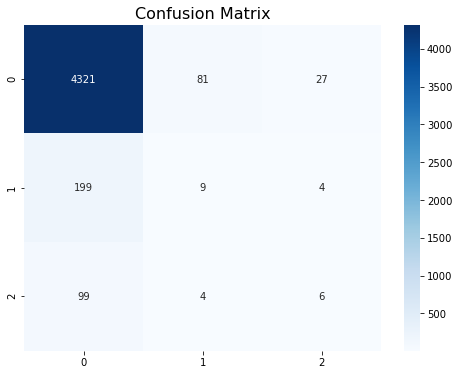

In [83]:
# Evaluate
print("ACCURACY: ", accuracy_score(y5_test, preds5))
cm = confusion_matrix(y5_test, preds5)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix', size=16)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues');

#### F-Score

In [84]:
print(classification_report(y5_test, preds5))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4429
           1       0.10      0.04      0.06       212
           2       0.16      0.06      0.08       109

    accuracy                           0.91      4750
   macro avg       0.40      0.36      0.37      4750
weighted avg       0.88      0.91      0.90      4750



#### SHAP

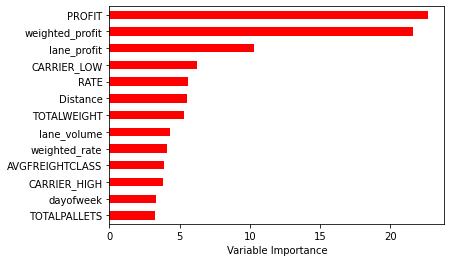

In [85]:
feature_importance = Model5.feature_importances_*100

rel_imp = pd.Series(feature_importance, 
                    index = X5_test.columns).sort_values(inplace = False)

rel_imp.T.plot(kind = 'barh', 
               color = 'r', )

plt.xlabel('Variable Importance')

plt.gca().legend_ = None

In [86]:
# Fits the explainer
explainer = shap.Explainer(Model5.predict, X5_test)
# Calculates the SHAP values - takes some time
shap_values = explainer(X5_test)

Permutation explainer: 4751it [12:10,  6.40it/s]                          


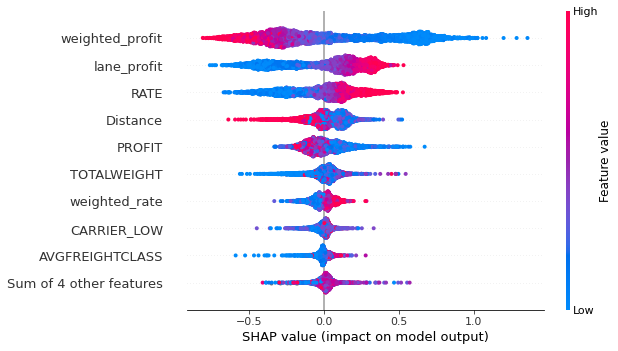

In [87]:
shap.plots.beeswarm(shap_values)

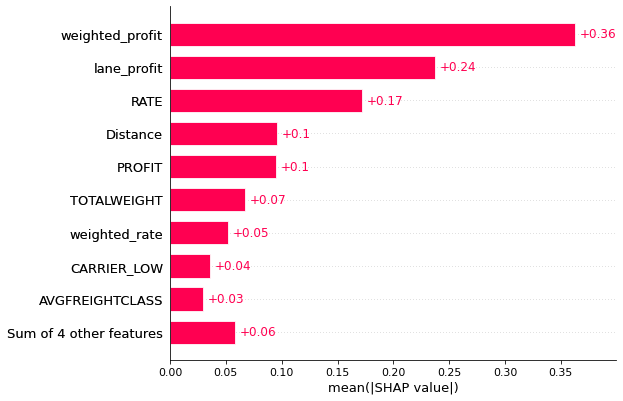

In [88]:
shap.plots.bar(shap_values)

### 3.3.6 Use only 2 classes and only 2 predictors: RATE, weighted_rate <a class="anchor" id="3.3.6"></a>

#### Only use 2 classes: CHOSEN = 1, 2

In [89]:
df2 = df.copy()

In [90]:
df2 = df2[df2['ORDERED']==1]

In [91]:
df2['CHOSEN'] = df2['CHOSEN'] - 1

In [92]:
df2['CHOSEN'].value_counts()

0    1146
1     644
Name: CHOSEN, dtype: int64

In [93]:
for_model2 = df2.groupby('QUOTEREQUESTID').agg({
    'RATE':'first',
    'COST':'first',
    'weighted_rate':'max',
    'weighted_cost':'max',
    'Distance':'first',
    'TOTALWEIGHT':'first',
    'TOTALPALLETS':'first',
    'AVGFREIGHTCLASS':'first',
    'ORIGINREGION':'first',
    'DESTINATIONREGION':'first',
    'CHOSEN':'max',
    'CARRIER_LOW':'first',
    'CARRIER_HIGH':'first',
    'lane_volume':'first',
    'lane_profit':'first',
    'dayofweek':'first',
    'QUOTEDDATETIME':'first'
}).reset_index()

In [94]:
for_model2['weighted_rate'] = for_model2['weighted_rate'].replace(to_replace=0, value=100000)
for_model2['weighted_cost'] = for_model2['weighted_cost'].replace(to_replace=0, value=99900)

In [95]:
for_model2_train = for_model2[for_model2['QUOTEDDATETIME']<="2022-05-31"]
for_model2_test = for_model2[for_model2['QUOTEDDATETIME']>"2022-05-31"]

In [96]:
for_model2_train['PROFIT'] = for_model2_train['RATE'] - for_model2_train['COST']
for_model2_train['weighted_profit'] = for_model2_train['weighted_rate'] - for_model2_train['weighted_cost']
for_model2_test['PROFIT'] = for_model2_test['RATE'] - for_model2_test['COST']
for_model2_test['weighted_profit'] = for_model2_test['weighted_rate'] - for_model2_test['weighted_cost']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

#### Train XGBoost

In [99]:
X6_train = for_model2_train[[
     'RATE',
     'weighted_rate',
]]

y6_train = for_model2_train['CHOSEN']

In [100]:
Model6 = XGBClassifier(base_score=0.5,
                    booster='gbtree',
                    colsample_bylevel=1,
                    colsample_bynode=1,
                    colsample_bytree=1,
                    gamma=0.5,
                    gpu_id=-1,
                    importance_type='gain',
                    interaction_constraints='',
                    learning_rate=.1,
                    max_delta_step=0,
                    max_depth=5,
                    min_child_weight=1,
                    missing=np.nan,
                    n_estimators=500,
                    n_jobs=0,
                    num_parallel_tree=1,
                    objective='binary:logistic',
                    random_state=0,
                    reg_alpha=0,
                    reg_lambda=1,
                    scale_pos_weight=None,
                    subsample=.5,
                    tree_method='exact',
                    validate_parameters=1,
                    verbosity=None
                    )

In [101]:
kfold = KFold(n_splits=10, random_state=7,shuffle=True)
results = cross_val_score(Model6, X6_train, y6_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 73.24% (3.25%)


In [102]:
Model6.fit(X6_train, y6_train)  

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

#### Confusion Matrix

In [103]:
X6_test= for_model2_test[[
     'RATE',
     'weighted_rate',
     
]]

y6_test = for_model2_test['CHOSEN']

In [104]:
preds6 = Model6.predict(X6_test)

ACCURACY:  0.7383177570093458


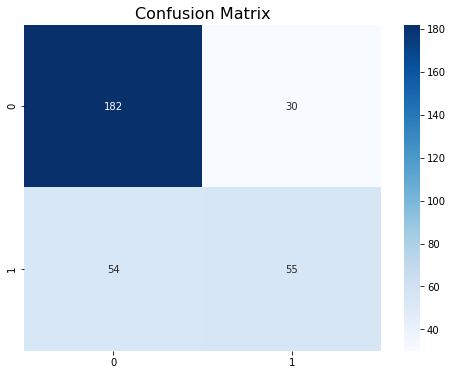

In [105]:
# Evaluate
print("ACCURACY: ", accuracy_score(y6_test, preds6))
cm = confusion_matrix(y6_test, preds6)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix', size=16)
sns.heatmap(cm, annot=True,fmt="d", cmap='Blues');

#### F-Score

In [106]:
print(classification_report(y6_test, preds6))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81       212
           1       0.65      0.50      0.57       109

    accuracy                           0.74       321
   macro avg       0.71      0.68      0.69       321
weighted avg       0.73      0.74      0.73       321



#### SHAP

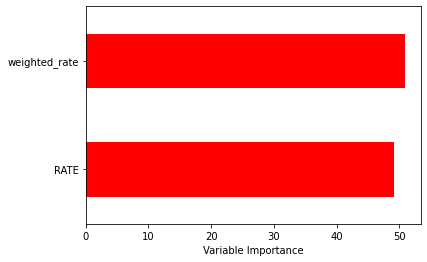

In [107]:
feature_importance = Model6.feature_importances_*100

rel_imp = pd.Series(feature_importance, 
                    index = X6_test.columns).sort_values(inplace = False)

rel_imp.T.plot(kind = 'barh', 
               color = 'r', )

plt.xlabel('Variable Importance')

plt.gca().legend_ = None

In [108]:
# Fits the explainer
explainer = shap.Explainer(Model6.predict, X6_test)
# Calculates the SHAP values - takes some time
shap_values = explainer(X6_test)

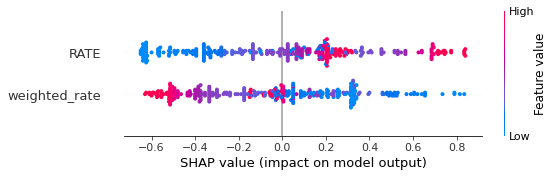

In [109]:
shap.plots.beeswarm(shap_values)

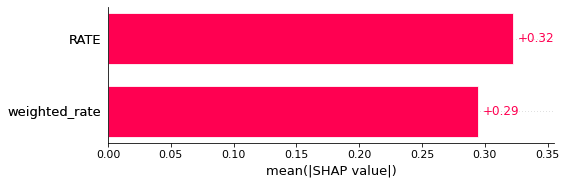

In [110]:
shap.plots.bar(shap_values)

### 3.3.7 Use only 2 classes and only 2 predictors: PROFIT, weighted_profit <a class="anchor" id="3.3.7"></a>

#### Train XGBoost

In [111]:
X7_train = for_model2_train[[
     'PROFIT',
     'weighted_profit'
]]

y7_train = for_model2_train['CHOSEN']

In [112]:
Model7 = XGBClassifier(base_score=0.5,
                    booster='gbtree',
                    colsample_bylevel=1,
                    colsample_bynode=1,
                    colsample_bytree=1,
                    gamma=0.5,
                    gpu_id=-1,
                    importance_type='gain',
                    interaction_constraints='',
                    learning_rate=.1,
                    max_delta_step=0,
                    max_depth=5,
                    min_child_weight=1,
                    missing=np.nan,
                    n_estimators=500,
                    n_jobs=0,
                    num_parallel_tree=1,
                    objective='binary:logistic',
                    random_state=0,
                    reg_alpha=0,
                    reg_lambda=1,
                    scale_pos_weight=None,
                    subsample=.5,
                    tree_method='exact',
                    validate_parameters=1,
                    verbosity=None
                    )

In [113]:
kfold = KFold(n_splits=10, random_state=7,shuffle=True)
results = cross_val_score(Model7, X7_train, y7_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 71.27% (4.08%)


In [114]:
Model7.fit(X7_train, y7_train)  

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

#### Confusion Matrix

In [115]:
X7_test= for_model2_test[[
     'PROFIT',
     'weighted_profit'
]]

y7_test = for_model2_test['CHOSEN']

In [116]:
preds7 = Model7.predict(X7_test)

ACCURACY:  0.6853582554517134


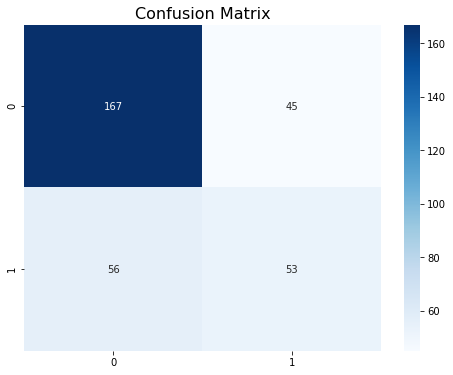

In [117]:
# Evaluate
print("ACCURACY: ", accuracy_score(y7_test, preds7))
cm = confusion_matrix(y7_test, preds7)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix', size=16)
sns.heatmap(cm, annot=True,fmt="d", cmap='Blues');

#### F-Score

In [118]:
print(classification_report(y7_test, preds7))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77       212
           1       0.54      0.49      0.51       109

    accuracy                           0.69       321
   macro avg       0.64      0.64      0.64       321
weighted avg       0.68      0.69      0.68       321



#### SHAP

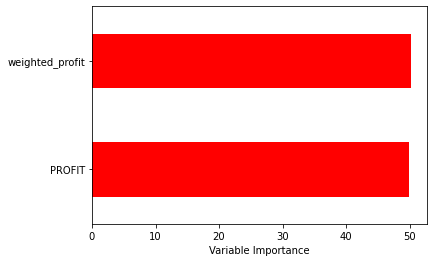

In [119]:
feature_importance = Model7.feature_importances_*100

rel_imp = pd.Series(feature_importance, 
                    index = X7_test.columns).sort_values(inplace = False)

rel_imp.T.plot(kind = 'barh', 
               color = 'r', )

plt.xlabel('Variable Importance')

plt.gca().legend_ = None

In [120]:
# Fits the explainer
explainer = shap.Explainer(Model7.predict, X7_test)
# Calculates the SHAP values - takes some time
shap_values = explainer(X7_test)

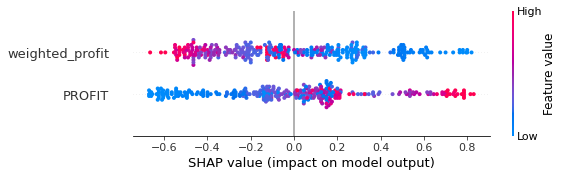

In [121]:
shap.plots.beeswarm(shap_values)

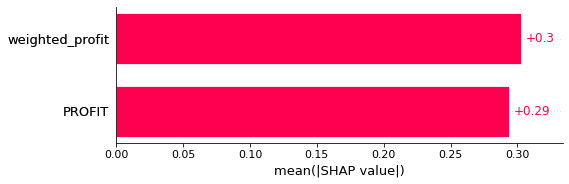

In [122]:
shap.plots.bar(shap_values)

## 3.4 CatBoost <a class="anchor" id="3.4"></a>

- CatBoost has the same principle as XGBoost but allows input to be categorical data.

In [123]:
chr_df1 = pd.read_csv('./clean_IMA2.csv')

In [124]:
chr_df_train = chr_df1[chr_df1['QUOTEDDATETIME'] < '2022-05-02']
chr_df_crossval = chr_df1[(chr_df1['QUOTEDDATETIME'] > '2022-05-01') & \
                          (chr_df1['QUOTEDDATETIME'] < '2022-06-02')]
chr_df_test = chr_df1[chr_df1['QUOTEDDATETIME'] > '2022-06-01']

In [125]:
def edit_train(df):
    
    for_model = df.groupby('QUOTEREQUESTID').agg({
    'RATE':'first',
    'COST': 'first',
    'weighted_rate':'sum',
    'weighted_cost':'sum',
    'Distance':'first',
    'TOTALWEIGHT':'first',
    'TOTALPALLETS':'first',
    'AVGFREIGHTCLASS':'first',
    'ORIGINREGION':'first',
    'DESTINATIONREGION':'first',
    'CARRIERCODE':'max',
    'Lane':'first',
    'CHOSEN': 'max'
    }).reset_index()
    
    df0 = for_model[for_model['CHOSEN']==0]
    df1 = for_model[for_model['CHOSEN']==1]
    df2 = for_model[for_model['CHOSEN']==2]

    df1_aug1 = df1.copy()
    df1_aug1['RATE'] = np.linspace(df1['RATE'], df1['COST'], 5)[1,]
    df1_aug2 = df1.copy()
    df1_aug2['RATE'] = np.linspace(df1['RATE'], df1['COST'], 5)[2,]
    df1_aug3 = df1.copy()
    df1_aug3['RATE'] = np.linspace(df1['RATE'], df1['COST'], 5)[3,]

    for_model = pd.concat([
        df0,
        df1,
        df1_aug1,
        df1_aug2,
        df1_aug3,
        df2])
    
    X = for_model[['RATE','weighted_rate','weighted_cost','COST','Distance', \
               'TOTALWEIGHT','TOTALPALLETS','AVGFREIGHTCLASS','Lane','CARRIERCODE']]
    y = for_model['CHOSEN']
    
    X = X.astype({'Lane':str,'CARRIERCODE':str})
    
    return X, y

In [126]:
def edit_crosstest(df):
    
    for_model = df.groupby('QUOTEREQUESTID').agg({
    'RATE':'first',
    'COST': 'first',
    'weighted_rate':'sum',
    'weighted_cost':'sum',
    'Distance':'first',
    'TOTALWEIGHT':'first',
    'TOTALPALLETS':'first',
    'AVGFREIGHTCLASS':'first',
    'ORIGINREGION':'first',
    'DESTINATIONREGION':'first',
    'CARRIERCODE':'max',
    'Lane':'first',
    'CHOSEN': 'max'
    }).reset_index()
    
    X = for_model[['RATE','weighted_rate','weighted_cost','COST','Distance', \
               'TOTALWEIGHT','TOTALPALLETS','AVGFREIGHTCLASS','Lane','CARRIERCODE']]
    y = for_model['CHOSEN']
    
    X = X.astype({'Lane':str, 'CARRIERCODE':str})
    
    return X, y

In [127]:
chr_df_trainX, chr_df_trainy  = edit_train(chr_df_train)
chr_df_crossvalX, chr_df_crossvaly  = edit_crosstest(chr_df_crossval)
chr_df_testX, chr_df_testy  = edit_crosstest(chr_df_test)

In [128]:
categorical_features_indices = [8,9]

In [129]:
eval_dataset = Pool(chr_df_crossvalX,
                    chr_df_crossvaly,
                    cat_features=categorical_features_indices)

In [130]:
model = CatBoostClassifier(iterations=10000, use_best_model=True, depth = 8, random_seed=12, loss_function='MultiClass')
model.fit(chr_df_trainX, chr_df_trainy, eval_set = eval_dataset, cat_features=categorical_features_indices, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#### SHAP

In [131]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(Pool(chr_df_trainX, chr_df_trainy, cat_features=categorical_features_indices))

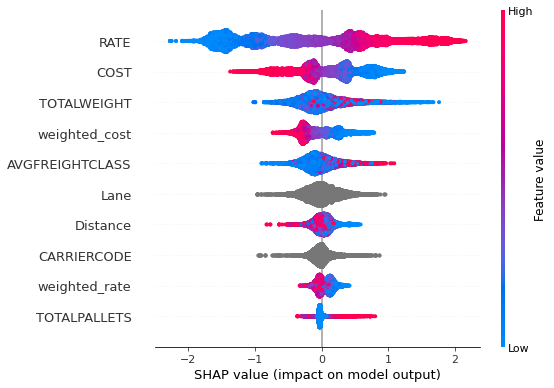

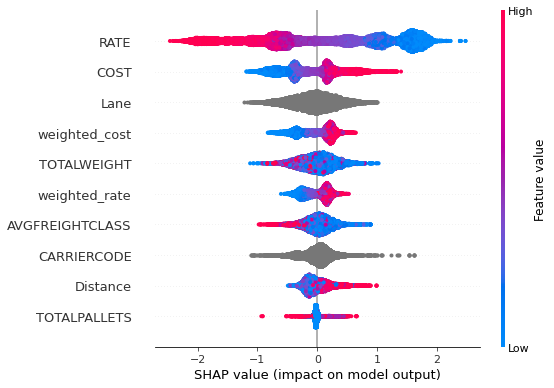

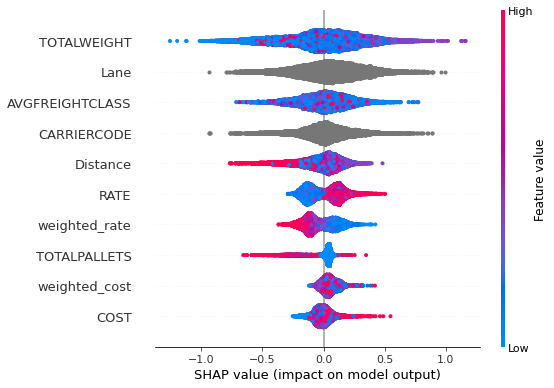

In [132]:
shap.summary_plot(shap_values[0],chr_df_trainX)
shap.summary_plot(shap_values[1],chr_df_trainX)
shap.summary_plot(shap_values[2],chr_df_trainX)

- The SHAP value summary plots are displayed after applying the CatBoost model to the testing data set. Each image shows how important each feature is in determining whether a quote is not purchased, is purchased with cheapest cost and is purchased with non-cheapest cost. Here, we see differences in how each feature affects a given choice.
- The grey region represents the categorical data.
- When the cheapest rate is high on average, the customer is more likely to not make any order.
- The choice in carrier is more impactful when customers choose the more expensive quotes.

#### Confusion Matrix

In [133]:
cv_dataset = Pool(data=chr_df_crossvalX,
                  label=chr_df_crossvaly,
                  cat_features=categorical_features_indices)

In [134]:
params = {"iterations": 100,
          "depth": 5,
          "loss_function": "MultiClass",
          "verbose": False}

In [135]:
scores = cv(cv_dataset,
            params,
            fold_count=2, 
            plot="False")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/2]

bestTest = 0.267462457
bestIteration = 99

Training on fold [1/2]

bestTest = 0.2671360336
bestIteration = 99



In [136]:
scores

,iterations,test-MultiClass-mean,test-MultiClass-std,train-MultiClass-mean,train-MultiClass-std
0,0,1.050288,0.000047,1.050270,0.000023
1,1,1.006527,0.000050,1.006502,0.000027
2,2,0.965848,0.000084,0.965731,0.000007
3,3,0.929011,0.000291,0.928851,0.000227
4,4,0.894150,0.000351,0.893976,0.000311
...,...,...,...,...,...
95,95,0.269095,0.000191,0.265876,0.000872
96,96,0.268621,0.000210,0.265375,0.000906
97,97,0.268158,0.000206,0.264903,0.000935
98,98,0.267722,0.000215,0.264429,0.000993


In [137]:
model.score(chr_df_trainX, chr_df_trainy)

0.9438250023622792

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


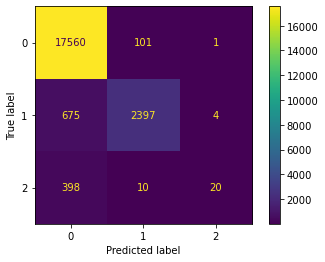

In [138]:
plot_confusion_matrix(model, chr_df_trainX, chr_df_trainy)

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


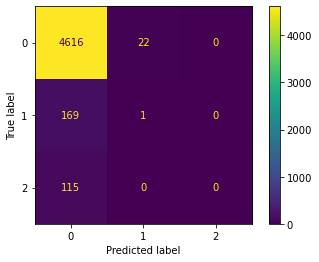

In [139]:
plot_confusion_matrix(model, chr_df_crossvalX, chr_df_crossvaly)

## 3.5 k-Nearest Neighborhoods (kNN) <a class="anchor" id="3.5"></a>

### Use only 2 predictors: RATE, weigted_rate <a class="anchor" id="3.5.1"></a>

#### Mean Error

In [140]:
error = []

# Calculating error for K values between 1 and 60
for i in range(1, 60):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X1_train, y1_train)
    pred_i = knn.predict(X1_test)
    error.append(np.mean(pred_i != y1_test))

Text(0, 0.5, 'Mean Error')

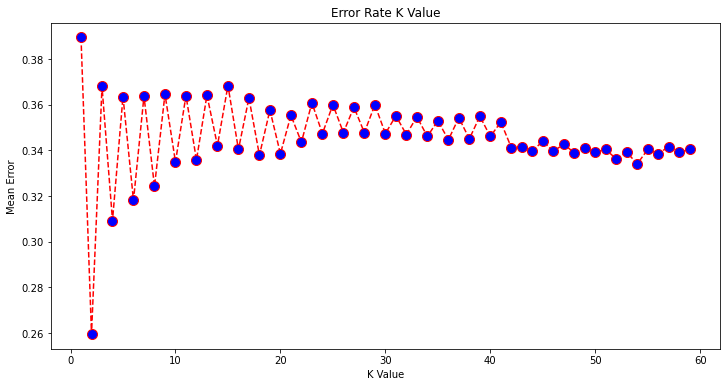

In [141]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 60), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

#### Testing Accuracy

In [142]:
# try K=1 through K=60 and record testing accuracy
k_range = range(1, 60)

# We can create Python dictionary using [] or dict()
scores = []

# We use a loop through the range 1 to 26
# We append the scores in the dictionary
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X1_train, y1_train)
    y_pred = knn.predict(X1_test)
    scores.append(accuracy_score(y1_test, y_pred))

Text(0, 0.5, 'Testing Accuracy')

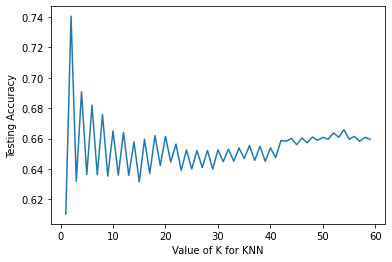

In [143]:
# allow plots to appear within the notebook
%matplotlib inline

# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

#### Confusion Matrix

In [144]:
# We choose k = 3
default_knn = KNeighborsClassifier(n_neighbors=3).fit(X1_train,y1_train)
preds_knn = default_knn.predict(X1_test)

ACCURACY:  0.632


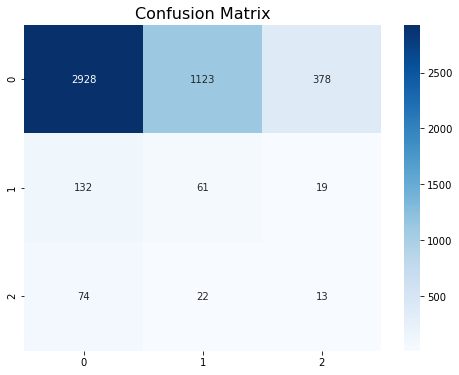

In [145]:
# Evaluate
print("ACCURACY: ", accuracy_score(y1_test, preds_knn))
cm = confusion_matrix(y1_test, preds_knn)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix', size=16)
sns.heatmap(cm, annot=True,fmt="d", cmap='Blues');

#### F-Score

In [146]:
print(classification_report(y1_test, preds_knn))

              precision    recall  f1-score   support

           0       0.93      0.66      0.77      4429
           1       0.05      0.29      0.09       212
           2       0.03      0.12      0.05       109

    accuracy                           0.63      4750
   macro avg       0.34      0.36      0.30      4750
weighted avg       0.87      0.63      0.73      4750



#### SHAP

In [147]:
# Fits the explainer
explainer = shap.Explainer(default_knn.predict, X1_test)
# Calculates the SHAP values - takes some time
shap_values = explainer(X1_test)

Exact explainer: 4751it [02:23, 30.22it/s]                          


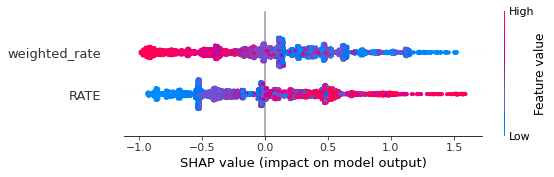

In [148]:
shap.plots.beeswarm(shap_values)

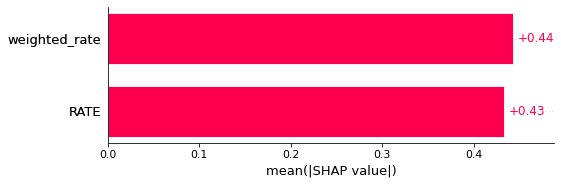

In [149]:
shap.plots.bar(shap_values)

# 4. Yield surface of expected value of profit <a class="anchor" id="4"></a>

## Less Augmentation for yield surfaces

In [151]:
for_model = df.groupby('QUOTEREQUESTID').agg({
    'RATE':'first',
    'COST':'first',
    'weighted_rate':'max',
    'weighted_cost':'max',
    'Distance':'first',
    'TOTALWEIGHT':'first',
    'TOTALPALLETS':'first',
    'AVGFREIGHTCLASS':'first',
    'ORIGINREGION':'first',
    'DESTINATIONREGION':'first',
    'CHOSEN':'max',
    'QUOTEDDATETIME':'first'
}).reset_index()
# the following is for cases when there is only one quote in the choice set. We want weighted_rate to be very high
# because we want the models to pick 0 or 1 in this cae.
for_model['weighted_rate'] = for_model['weighted_rate'].replace(to_replace=0, value=100000)
for_model['weighted_cost'] = for_model['weighted_cost'].replace(to_replace=0, value=99900)

In [152]:
for_model_train=for_model[for_model['QUOTEDDATETIME']<="2022-05-31"]
for_model_test=for_model[for_model['QUOTEDDATETIME']>"2022-05-31"]


In [153]:
df0 = for_model_train[for_model_train['CHOSEN']==0]
df1 = for_model_train[for_model_train['CHOSEN']==1]
df2 = for_model_train[for_model_train['CHOSEN']==2]

N_augmentations_class1=5
X=np.linspace(df1['RATE'], df1['COST'], N_augmentations_class1)
df1_dict={}
for i in range(N_augmentations_class1-2):
    df1_dict[i+1]=df1.copy()
    df1_dict[i+1]['RATE'] = X[i+1,]
    
N_augmentations_class2=5
X=np.linspace(df2['weighted_rate'], df2['weighted_cost'], N_augmentations_class2)
df2_dict={}
for i in range(N_augmentations_class2-2):
    df2_dict[i+1]=df2.copy()
    df2_dict[i+1]['weighted_rate'] = X[i+1,]

df1_aug=pd.concat(df1_dict)
df2_aug=pd.concat(df2_dict)
for_model_train = pd.concat([
    df0,
    df1,
    df2,
    df1_aug,
    df2_aug])

In [154]:
for_model_train['Profit']=for_model_train['RATE']-for_model_train['COST']
for_model_train['weighted_profit']=for_model_train['weighted_rate']-for_model_train['weighted_cost']
for_model_test['Profit']=for_model_test['RATE']-for_model_test['COST']
for_model_test['weighted_profit']=for_model_test['weighted_rate']-for_model_test['weighted_cost']



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [155]:
for_model_train['CHOSEN'].value_counts()

0    22078
1     3736
2     2140
Name: CHOSEN, dtype: int64

## Distance 0-200 miles

In [156]:
X1= for_model_train[for_model_train['Distance']<200][['RATE','weighted_rate','COST','weighted_cost','CHOSEN','Profit','weighted_profit']]
X1=X1[ (X1['RATE']<100000) & (X1['weighted_rate']<100000) ]

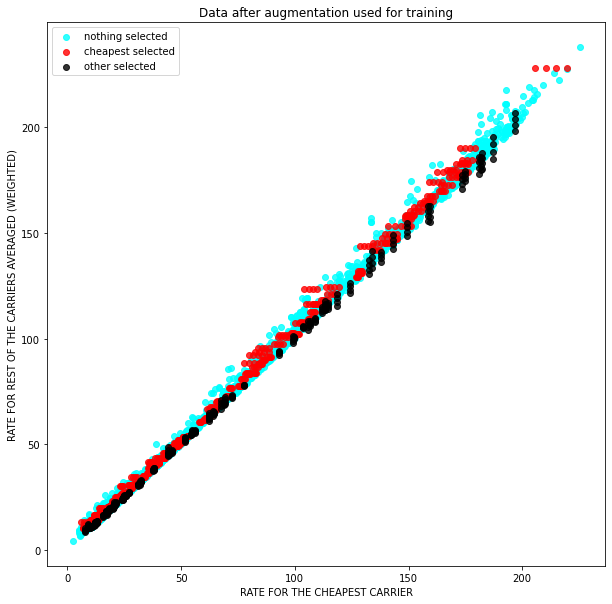

In [157]:
plt.figure(figsize=(10,10))
plt.xlabel('RATE FOR THE CHEAPEST CARRIER')
plt.ylabel('RATE FOR REST OF THE CARRIERS AVERAGED (WEIGHTED)')
plt.scatter(X1[X1["CHOSEN"]==0]['RATE'],X1[X1["CHOSEN"]==0]['weighted_rate'],color=(0,1,1,.8),label="nothing selected")
plt.scatter(X1[X1["CHOSEN"]==1]['RATE'],X1[X1["CHOSEN"]==1]['weighted_rate'],color='red',alpha=.8,label="cheapest selected")
plt.scatter(X1[X1["CHOSEN"]==2]['RATE'],X1[X1["CHOSEN"]==2]['weighted_rate'],color='black',alpha=.8,label="other selected")
plt.legend()

plt.title("Data after augmentation used for training")
plt.show()

In [158]:
from sklearn.neighbors import NearestNeighbors 
neigh = NearestNeighbors(n_neighbors=60)
neigh.fit(X1[['RATE','weighted_rate']])
xs=[]
ys=[]

for x in range(0,250):
    for y in range(0,250):
        if y<x+50 and y>x:
            xs.append(x)
            ys.append(y)
        else:
            pass     
grid_search=pd.DataFrame({"RATE":xs, "weighted_rate":ys})
X1=X1.reset_index(drop=True)
neighbors=neigh.kneighbors(grid_search,return_distance=False)  


In [159]:
from tqdm.notebook import tqdm
expected_profit_list=[]
for i in tqdm(range(len(neighbors))):
    P=X1.iloc[neighbors[i]]
    unchosen=P[P['CHOSEN']==0]
    cheapest=P[P['CHOSEN']==1]
    not_cheapest=P[P['CHOSEN']==2]
    proportion=np.array([unchosen.shape[0],cheapest.shape[0],not_cheapest.shape[0]])/25

    profit=cheapest['Profit'].mean()
    weighted_profit=not_cheapest['weighted_profit'].mean()
    profit_array=np.array([0,profit,weighted_profit])
    profit_array[np.isnan(profit_array)] = 0

    expected_profit=np.sum(proportion*profit_array)
    expected_profit_list.append(expected_profit)
    
    
grid_search['expected_profit']=expected_profit_list
    
    

  0%|          | 0/11025 [00:00<?, ?it/s]

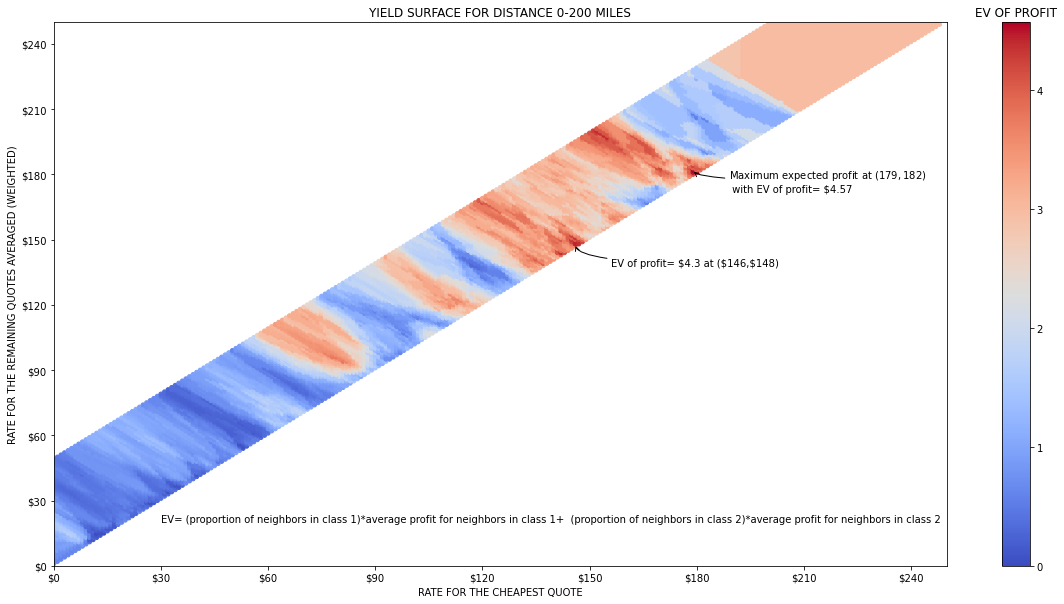

In [160]:
import matplotlib.pyplot as plt
from matplotlib import cm

a = '\\frac{a}{b}'

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)


im=plt.scatter('RATE', 'weighted_rate', c='expected_profit',s=16, cmap=cm.coolwarm, data=grid_search)
plt.xlabel('RATE FOR THE CHEAPEST QUOTE')
plt.ylabel('RATE FOR THE REMAINING QUOTES AVERAGED (WEIGHTED)')

plt.xlim(0, 250)
plt.ylim(0,250)

ax.set_xticks(np.arange(0, 250, 30))
ax.set_yticks(np.arange(0, 250, 30))

ax.xaxis.set_major_formatter('${x:1.0f}')
ax.yaxis.set_major_formatter('${x:1.0f}')

clb=plt.colorbar()
clb.ax.set_title('EV OF PROFIT')

ax.annotate('Maximum expected profit at ($179,$182)\n with EV of profit= $4.57', (179, 182), xytext=(179+10, 182-10), 
    arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90"))
ax.annotate('EV of profit= $4.3 at ($146,$148)', (146, 148), xytext=(146+10, 148-10), 
    arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90"))

ax.annotate('EV= (proportion of neighbors in class 1)*average profit for neighbors in class 1+  (proportion of neighbors in class 2)*average profit for neighbors in class 2', (30, 20))



ax.set_title("YIELD SURFACE FOR DISTANCE 0-200 MILES")  # Add a title to the axes.




plt.show()

- We constructed a grid of points in the Rate for cheapest vs. Average Rate for the other carriers plane.
- For each grid point, we searched its k-nearest neighbors in the dataset (k = 40).
- Notice that there are several regions with red shade corresponding to large expected profit.
    - We obtain the maximum expected profit \\$4.57 when the rate for the cheapest quote is \\$179 and the average rate for the remaining quotes is \\$182.
    - We obtain another large expected profit \\$4.3 when the rate for the cheapest quote is \\$146 and the average rate for the remaining quotes is \\$148.
- From XGBoost, we know that the customer is more likely willing to buy the more expensive quote. 

## Distance 600 to 800

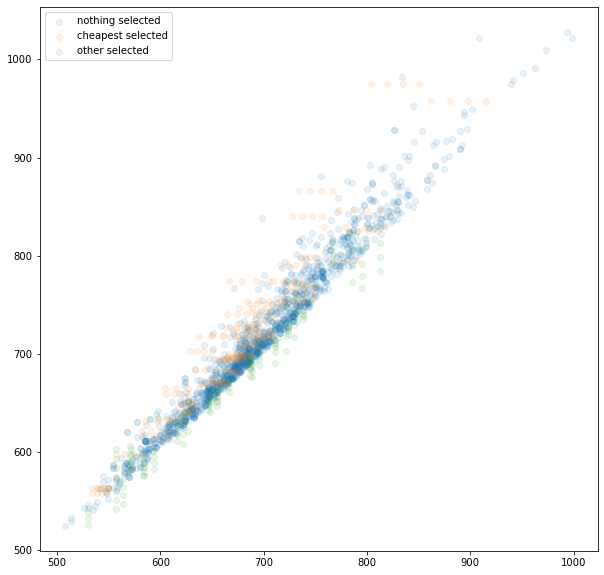

In [161]:
X2= for_model_train[for_model_train['Distance'].between(600,800)][['RATE','weighted_rate','COST','weighted_cost','CHOSEN','Profit','weighted_profit']]
X2=X2[ (X2['RATE']<100000) & (X2['weighted_rate']<100000)]

neigh = NearestNeighbors(n_neighbors=40)
neigh.fit(X2[['RATE','weighted_rate']])

plt.figure(figsize=(10,10))
plt.scatter(X2[X2["CHOSEN"]==0]['RATE'],X2[X2["CHOSEN"]==0]['weighted_rate'],alpha=.1,label="nothing selected")
plt.scatter(X2[X2["CHOSEN"]==1]['RATE'],X2[X2["CHOSEN"]==1]['weighted_rate'],alpha=.1,label="cheapest selected")
plt.scatter(X2[X2["CHOSEN"]==2]['RATE'],X2[X2["CHOSEN"]==2]['weighted_rate'],alpha=.1,label="other selected")
plt.legend()
plt.show()

In [162]:
neigh = NearestNeighbors(n_neighbors=60)
neigh.fit(X2[['RATE','weighted_rate']])


xs=[]
ys=[]

for x in range(500,1000):
    for y in range(500,1000):
        if y<x+100 and y>x:
            xs.append(x)
            ys.append(y)
        else:
            pass

grid_search2=pd.DataFrame({"RATE":xs, "weighted_rate":ys})  
X2=X2.reset_index(drop=True)
neighbors=neigh.kneighbors(grid_search2,return_distance=False)

from tqdm.notebook import tqdm
expected_profit_list=[]
for i in tqdm(range(len(neighbors))):
    P=X2.iloc[neighbors[i]]
    unchosen=P[P['CHOSEN']==0]
    cheapest=P[P['CHOSEN']==1]
    not_cheapest=P[P['CHOSEN']==2]
    proportion=np.array([unchosen.shape[0],cheapest.shape[0],not_cheapest.shape[0]])/25

    profit=cheapest['Profit'].mean()
    weighted_profit=not_cheapest['weighted_profit'].mean()
    profit_array=np.array([0,profit,weighted_profit])
    profit_array[np.isnan(profit_array)] = 0

    expected_profit=np.sum(proportion*profit_array)
    expected_profit_list.append(expected_profit)
    
grid_search2['expected_profit']=expected_profit_list  

    
    

  0%|          | 0/44550 [00:00<?, ?it/s]

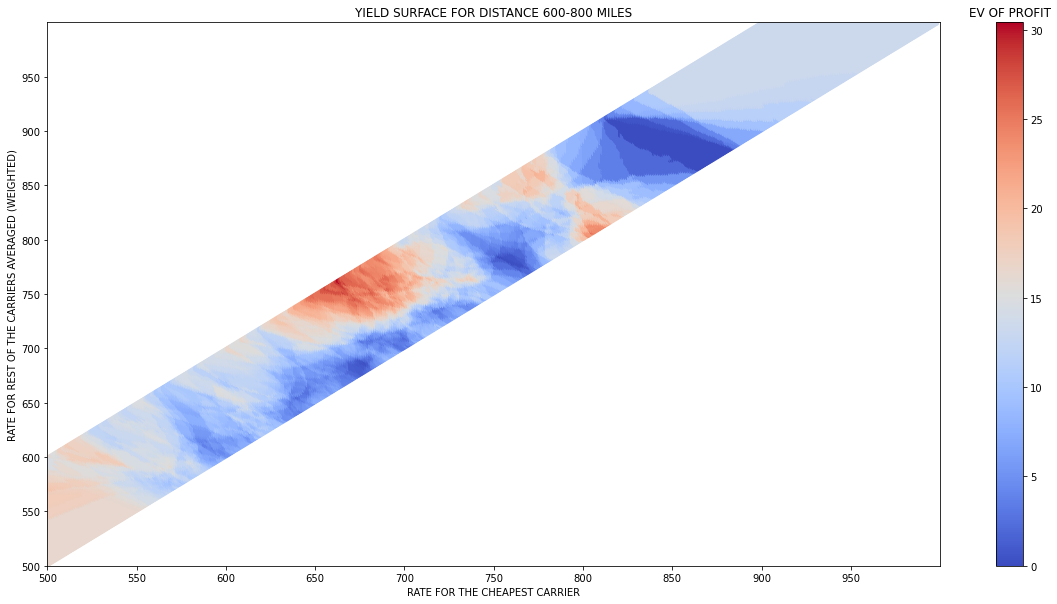

In [163]:
import matplotlib.pyplot as plt
from matplotlib import cm

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)


im=plt.scatter('RATE', 'weighted_rate', c='expected_profit',s=16, cmap=cm.coolwarm, data=grid_search2)
plt.xlabel('RATE FOR THE CHEAPEST CARRIER')
plt.ylabel('RATE FOR REST OF THE CARRIERS AVERAGED (WEIGHTED)')

plt.xlim(500, 1000)
plt.ylim(500,1000)

ax.set_xticks(np.arange(500, 1000, 50))
ax.set_yticks(np.arange(500, 1000, 50))


clb=plt.colorbar()
clb.ax.set_title('EV OF PROFIT')


ax.set_title("YIELD SURFACE FOR DISTANCE 600-800 MILES")  # Add a title to the axes.




plt.show()

## Distance 1000-2000 miles

In [164]:
X3= for_model_train[for_model_train['Distance'].between(1000,2000)][['RATE','weighted_rate','COST','weighted_cost','CHOSEN','Profit','weighted_profit']]
X3=X3[ (X3['RATE']<100000) & (X3['weighted_rate']<100000) ]


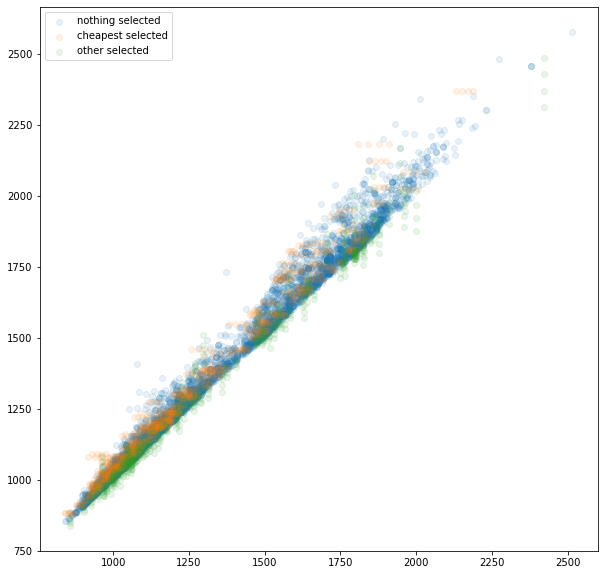

In [165]:
plt.figure(figsize=(10,10))
plt.scatter(X3[X3["CHOSEN"]==0]['RATE'],X3[X3["CHOSEN"]==0]['weighted_rate'],alpha=.1,label="nothing selected")
plt.scatter(X3[X3["CHOSEN"]==1]['RATE'],X3[X3["CHOSEN"]==1]['weighted_rate'],alpha=.1,label="cheapest selected")
plt.scatter(X3[X3["CHOSEN"]==2]['RATE'],X3[X3["CHOSEN"]==2]['weighted_rate'],alpha=.1,label="other selected")
plt.legend()
plt.show()

In [166]:
neigh = NearestNeighbors(n_neighbors=60)
neigh.fit(X3[['RATE','weighted_rate']])

xs=[]
ys=[]

for x in range(750,2500):
    for y in range(750,2500):
        if y<x+100 and y>x:
            xs.append(x)
            ys.append(y)
        else:
            pass

grid_search3=pd.DataFrame({"RATE":xs, "weighted_rate":ys})
X3=X3.reset_index(drop=True)
neighbors=neigh.kneighbors(grid_search3,return_distance=False)

In [167]:
from tqdm.notebook import tqdm
expected_profit_list=[]
for i in tqdm(range(len(neighbors))):
    P=X3.iloc[neighbors[i]]
    unchosen=P[P['CHOSEN']==0]
    cheapest=P[P['CHOSEN']==1]
    not_cheapest=P[P['CHOSEN']==2]
    proportion=np.array([unchosen.shape[0],cheapest.shape[0],not_cheapest.shape[0]])/25

    profit=cheapest['Profit'].mean()
    weighted_profit=not_cheapest['weighted_profit'].mean()
    profit_array=np.array([0,profit,weighted_profit])
    profit_array[np.isnan(profit_array)] = 0

    expected_profit=np.sum(proportion*profit_array)
    expected_profit_list.append(expected_profit)
grid_search3['expected_profit']=expected_profit_list  
      

  0%|          | 0/168300 [00:00<?, ?it/s]

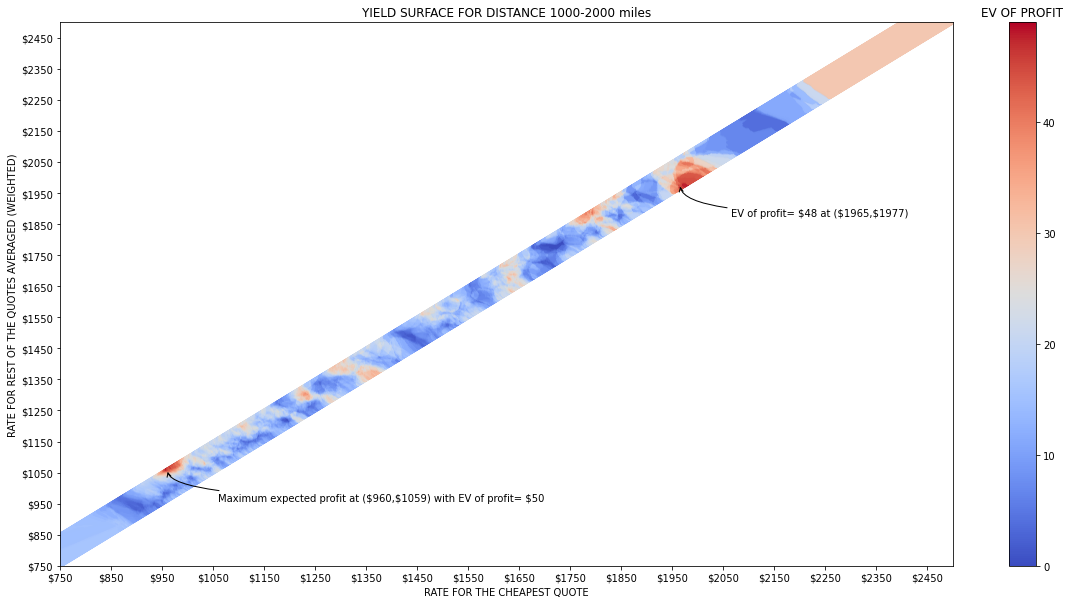

In [168]:
import matplotlib.pyplot as plt
from matplotlib import cm

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)


im=plt.scatter('RATE', 'weighted_rate', c='expected_profit',s=12, cmap=cm.coolwarm, data=grid_search3)
plt.xlabel('RATE FOR THE CHEAPEST QUOTE')
plt.ylabel('RATE FOR REST OF THE QUOTES AVERAGED (WEIGHTED)')

plt.xlim(750, 2500)
plt.ylim(750,2500)

ax.set_xticks(np.arange(750, 2500, 100))
ax.set_yticks(np.arange(750, 2500, 100))


clb=plt.colorbar()
clb.ax.set_title('EV OF PROFIT')


ax.set_title("YIELD SURFACE FOR DISTANCE 1000-2000 miles")  # Add a title to the axes.

ax.annotate('Maximum expected profit at ($960,$1059) with EV of profit= $50', (960, 1059), xytext=(960+100, 1059-100), 
    arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90"))

ax.annotate('EV of profit= $48 at ($1965,$1977)', (1965, 1977), xytext=(1965+100, 1977-100), 
    arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90"))

ax.xaxis.set_major_formatter('${x:1.0f}')
ax.yaxis.set_major_formatter('${x:1.0f}')


plt.show()

- From XGBoost we know that for longer distances the customer is more likely to choose the cheapest quote.
- We obtain the maximum expected profit \\$50 when the rate for the cheapest quote is \\$960 and the average rate for the remaining quotes is \\$1059.
- We obtain another large expected profit \\$48 when the rate for the cheapest quote is \\$1965 and the average rate for the remaining quotes is \\$1977.

## Freight Class <60

In [169]:
X4= for_model_train[for_model_train['AVGFREIGHTCLASS']<60][['RATE','weighted_rate','COST','weighted_cost','CHOSEN','Profit','weighted_profit']]
X4=X4[ (X4['RATE']<100000) & (X4['weighted_rate']<100000) ]



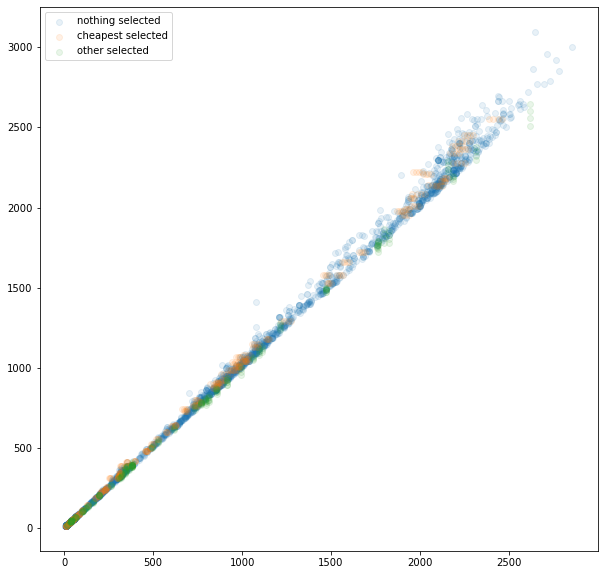

In [170]:
plt.figure(figsize=(10,10))
plt.scatter(X4[X4["CHOSEN"]==0]['RATE'],X4[X4["CHOSEN"]==0]['weighted_rate'],alpha=.1,label="nothing selected")
plt.scatter(X4[X4["CHOSEN"]==1]['RATE'],X4[X4["CHOSEN"]==1]['weighted_rate'],alpha=.1,label="cheapest selected")
plt.scatter(X4[X4["CHOSEN"]==2]['RATE'],X4[X4["CHOSEN"]==2]['weighted_rate'],alpha=.1,label="other selected")
plt.legend()
plt.show()

In [171]:
neigh = NearestNeighbors(n_neighbors=70)
neigh.fit(X4[['RATE','weighted_rate']])

xs=[]
ys=[]

for x in range(0,3000):
    for y in range(0,3000):
        if y<x+100 and y>x:
            xs.append(x)
            ys.append(y)
        else:
            pass
grid_search4=pd.DataFrame({"RATE":xs, "weighted_rate":ys})
X4=X4.reset_index(drop=True)
neighbors=neigh.kneighbors(grid_search4,return_distance=False)
    

In [172]:
from tqdm.notebook import tqdm
expected_profit_list=[]
for i in tqdm(range(len(neighbors))):
    P=X4.iloc[neighbors[i]]
    unchosen=P[P['CHOSEN']==0]
    cheapest=P[P['CHOSEN']==1]
    not_cheapest=P[P['CHOSEN']==2]
    proportion=np.array([unchosen.shape[0],cheapest.shape[0],not_cheapest.shape[0]])/25

    profit=cheapest['Profit'].mean()
    weighted_profit=not_cheapest['weighted_profit'].mean()
    profit_array=np.array([0,profit,weighted_profit])
    profit_array[np.isnan(profit_array)] = 0

    expected_profit=np.sum(proportion*profit_array)
    expected_profit_list.append(expected_profit)
grid_search4['expected_profit']=expected_profit_list      

  0%|          | 0/292050 [00:00<?, ?it/s]

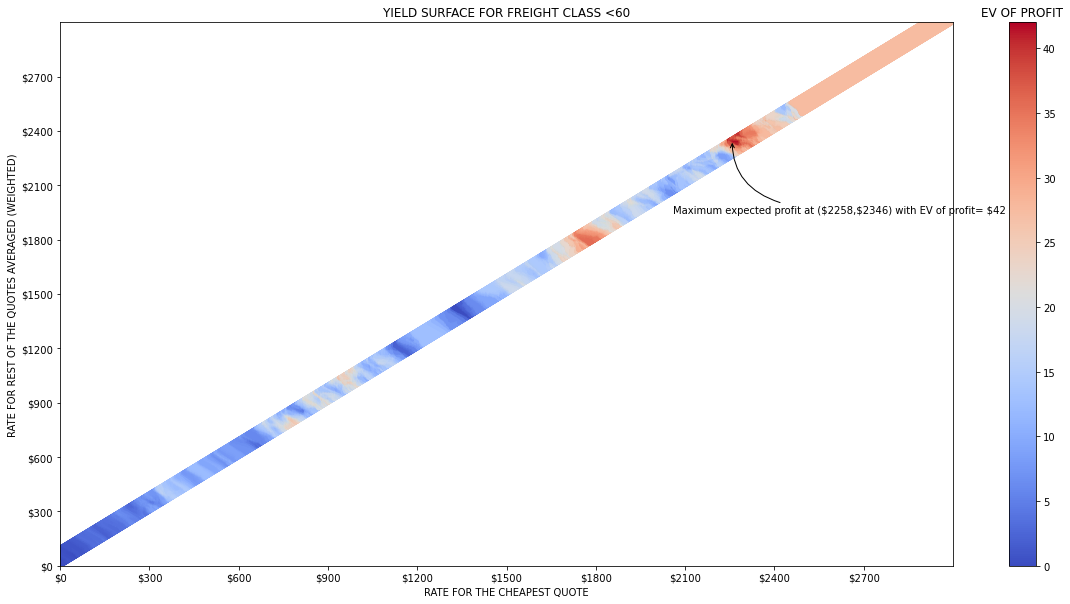

In [173]:
import matplotlib.pyplot as plt
from matplotlib import cm

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)


im=plt.scatter('RATE', 'weighted_rate', c='expected_profit',s=12, cmap=cm.coolwarm, data=grid_search4)
plt.xlabel('RATE FOR THE CHEAPEST QUOTE')
plt.ylabel('RATE FOR REST OF THE QUOTES AVERAGED (WEIGHTED)')

plt.xlim(0, 3000)
plt.ylim(0,3000)

ax.set_xticks(np.arange(0, 3000, 300))
ax.set_yticks(np.arange(0, 3000, 300))


clb=plt.colorbar()
clb.ax.set_title('EV OF PROFIT')


ax.set_title("YIELD SURFACE FOR FREIGHT CLASS <60")  # Add a title to the axes.

ax.annotate('Maximum expected profit at ($2258,$2346) with EV of profit= $42', (2258, 2346), xytext=(2258-200, 2346-400), 
    arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90"))

ax.xaxis.set_major_formatter('${x:1.0f}')
ax.yaxis.set_major_formatter('${x:1.0f}')


plt.show()

- From XGBoost we know that for low freight class the customer is more willing to buy one of the more expensive quotes.
- We obtain the maximum expected profit \\$42 when the rate for the cheapest quote is \\$2258 and the average rate for the remaining quotes is \\$2346.

## FREIGHT CLASS >400

In [174]:
X5= for_model_train[for_model_train['AVGFREIGHTCLASS']>400][['RATE','weighted_rate','COST','weighted_cost','CHOSEN','Profit','weighted_profit']]
X5=X5[ (X5['RATE']<100000) & (X5['weighted_rate']<100000) ]

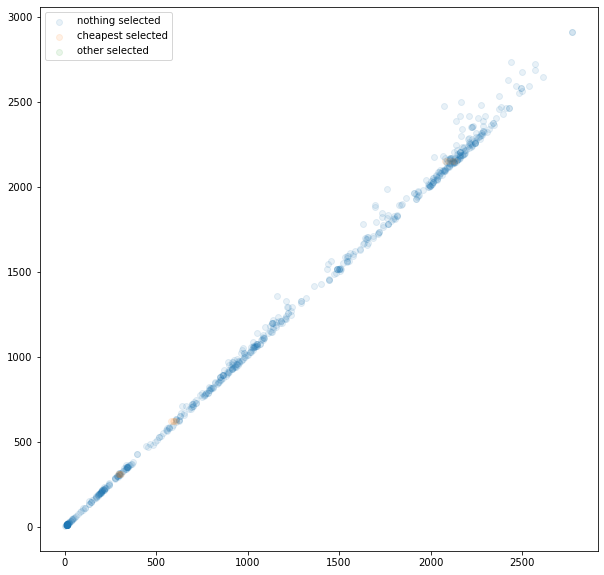

In [175]:
plt.figure(figsize=(10,10))
plt.scatter(X5[X5["CHOSEN"]==0]['RATE'],X5[X5["CHOSEN"]==0]['weighted_rate'],alpha=.1,label="nothing selected")
plt.scatter(X5[X5["CHOSEN"]==1]['RATE'],X5[X5["CHOSEN"]==1]['weighted_rate'],alpha=.1,label="cheapest selected")
plt.scatter(X5[X5["CHOSEN"]==2]['RATE'],X5[X5["CHOSEN"]==2]['weighted_rate'],alpha=.1,label="other selected")
plt.legend()
plt.show()

In [176]:
neigh = NearestNeighbors(n_neighbors=70)
neigh.fit(X5[['RATE','weighted_rate']])

xs=[]
ys=[]

for x in range(0,3000):
    for y in range(0,3000):
        if y<x+100 and y>x:
            xs.append(x)
            ys.append(y)
        else:
            pass
grid_search5=pd.DataFrame({"RATE":xs, "weighted_rate":ys})
X5=X5.reset_index(drop=True)
neighbors=neigh.kneighbors(grid_search5,return_distance=False)
    

In [177]:
from tqdm.notebook import tqdm
expected_profit_list=[]
for i in tqdm(range(len(neighbors))):
    P=X5.iloc[neighbors[i]]
    unchosen=P[P['CHOSEN']==0]
    cheapest=P[P['CHOSEN']==1]
    not_cheapest=P[P['CHOSEN']==2]
    proportion=np.array([unchosen.shape[0],cheapest.shape[0],not_cheapest.shape[0]])/25

    profit=cheapest['Profit'].mean()
    weighted_profit=not_cheapest['weighted_profit'].mean()
    profit_array=np.array([0,profit,weighted_profit])
    profit_array[np.isnan(profit_array)] = 0

    expected_profit=np.sum(proportion*profit_array)
    expected_profit_list.append(expected_profit)
grid_search5['expected_profit']=expected_profit_list  
    

    
    

  0%|          | 0/292050 [00:00<?, ?it/s]

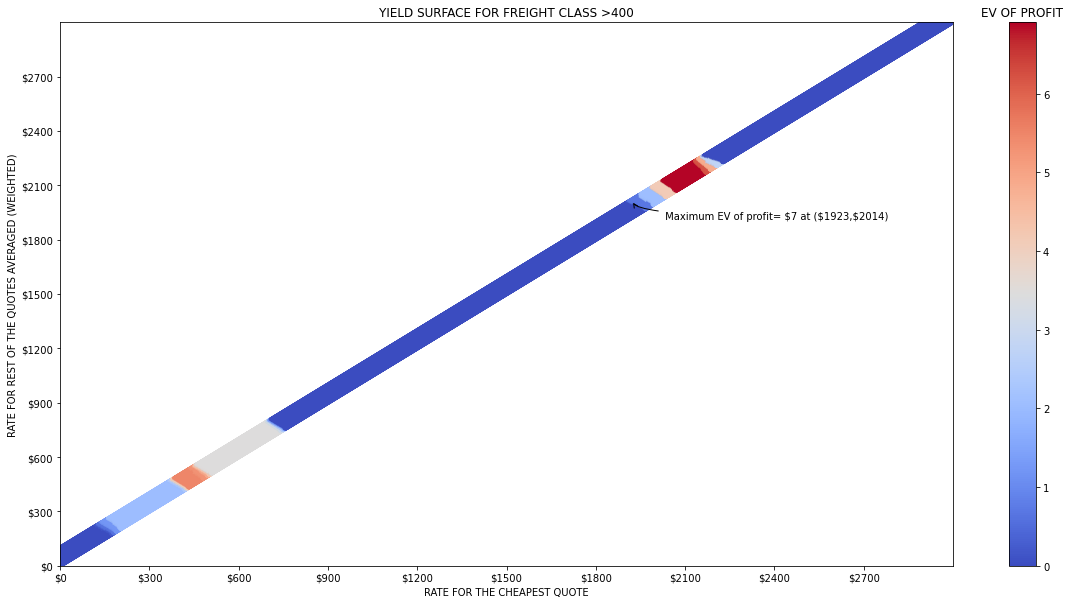

In [178]:
import matplotlib.pyplot as plt
from matplotlib import cm

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)


im=plt.scatter('RATE', 'weighted_rate', c='expected_profit',s=12, cmap=cm.coolwarm, data=grid_search5)
plt.xlabel('RATE FOR THE CHEAPEST QUOTE')
plt.ylabel('RATE FOR REST OF THE QUOTES AVERAGED (WEIGHTED)')

plt.xlim(0, 3000)
plt.ylim(0,3000)

ax.set_xticks(np.arange(0, 3000, 300))
ax.set_yticks(np.arange(0, 3000, 300))


clb=plt.colorbar()
clb.ax.set_title('EV OF PROFIT')


ax.set_title("YIELD SURFACE FOR FREIGHT CLASS >400")  # Add a title to the axes.


ax.annotate(' Maximum EV of profit= $7 at ($1923,$2014)', (1923, 2014), xytext=(1923+100, 2014-100), 
    arrowprops = dict(  arrowstyle="->",
                        connectionstyle="angle3,angleA=0,angleB=-90"))

ax.xaxis.set_major_formatter('${x:1.0f}')
ax.yaxis.set_major_formatter('${x:1.0f}')


plt.show()

- From XGBoost we know that for high freight class the customer is less willing to buy one of the more expensive quotes.
- We obtain the maximum expected profit \\$7 when the rate for the cheapest quote is \\$1923 and the average rate for the remaining quotes is \\$2014.

# 5. Conclusion <a class="anchor" id="5"></a>

- The expected profit can be maximized in regards to the company’s preferences. 
    - For example, if the company wants to push for high volume, then it can set its prices at high EV regions with lower rates; but if it wants to push for more profit, then sacrificing  can set its prices at high EV regions with higher rates. 
- Feature importance from XGBoost offers a good  introductory level framework for creating dynamic pricing strategies. 
    - For example, increases in customers purchasing the cheapest quote will require less concern for total pallets but more concern for distance.
- We have a way to test and explore our pricing strategies using Thompson Sampling.
    - For example, the success (and failure) of strategies can be run and measmured in real time.
- The SHAP values help us explore the impact of different features on model output.
    - For example, the carrier would impact much more when the customer select more expensive quotes than the cheapest one.

# Acknowlegement <a class="anchor" id="6"></a>

We want to take the time to thank Brady Thomas for all the work and time he has invested into us and this project. We leave the IMA Math to Industry Bootcamp and Brady’s Membership having been exposed to many valuable topics in Data Science and Machine Learning. Additionally, we want to thank Daniel Spirn and Thomas Hoft for leading, directing and offering such a program. We feel the resources and experiences this program provided and curated will take us very far. Thank you, again!